<a href="https://colab.research.google.com/github/jdjdjafari/biomechstudent/blob/master/latest_version_round1(3_levelfilters%2Bjerk%2Baverage_cycles)_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import scipy as sci 
import matplotlib.pyplot as plt 
import pandas as pd 
import pyhht
from pyhht.visualization import plot_imfs
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from nolitsa import delay, noise, dimension 
import nolds 
#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.tri as mtri
from scipy import signal 
from entropy import *

In [ ]:
#load data 
A=pd.read_csv('round1.csv')

In [ ]:
#define data : acceleration raw data, processed data including linear acceleration, quaternion and euler
accelx=np.array(A[' AccX (g)'])
accely=np.array(A[' AccY (g)'])
accelz=np.array(A[' AccZ (g)'])
t=np.array(A[' TimeStamp (s)'])
q1=np.array(A[' QuatW'])
q2=np.array(A[' QuatX'])
q3=np.array(A[' QuatY'])
q4=np.array(A[' QuatZ'])
linaccelx=np.array(A[' LinAccX (g)'])
linaccely=np.array(A[' LinAccY (g)'])
linaccelz=np.array(A[' LinAccZ (g)'])
eulerx=np.array(A[' EulerX (deg)'])
eulery=np.array(A[' EulerY (deg)'])
eulerZ=np.array(A[' EulerZ (deg)'])
angular_velx=np.array(A[' GyroX (deg/s)'])
angular_vely=np.array(A[' GyroY (deg/s)'])
angular_velz=np.array(A[' GyroZ (deg/s)'])

In [ ]:
#define KPSS for stationarity 
def kpss_test(timeseries):
    print('results of KPSS test:')
    kpsstest=kpss(timeseries,regression='c')
    kpss_output=pd.Series(kpsstest[0:3], index=['test statistics', 'p value', 'lags used'])
    for key, value in kpsstest[3].items():
        kpss_output['critical value (%s) %key']=value 
    print(kpss_output)
    
#ADF test for stationarity 
def adf_test(timeseries):
    #perform Dickey fuuler test
    print ('Results of dickey fuller test:')
    dftest=adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['test statistics','p value','#Log used','number of observations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical value (%s) %key']=value
    print(dfoutput)

(10000, 10500)

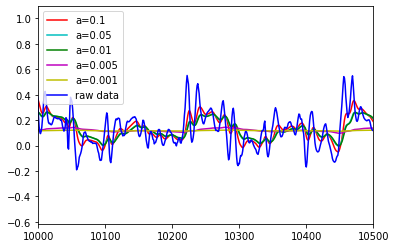

In [ ]:
#Low pass filter defined by Sensor, we check to find the best constant 
U=accelx
target1=np.zeros(len(U))

for i in range(len(U)-1):
    target1[i]=0.9*target1[i-1]+0.1*U[i]
    a=target1[i]
    np.insert(target1,0,a)
    
target2=np.zeros(len(U))

for i in range(len(U)-1):
    target2[i]=(1-0.05)*target2[i-1]+0.05*U[i]
    a=target2[i]
    np.insert(target2,0,a)
    
target3=np.zeros(len(U))

for i in range(len(U)-1):
    target3[i]=(1-0.01)*target2[i-1]+0.01*U[i]
    a=target3[i]
    np.insert(target1,0,a)
    
target4=np.zeros(len(U))

for i in range(len(U)-1):
    target4[i]=(1-0.005)*target4[i-1]+0.005*U[i]
    a=target4[i]
    np.insert(target4,0,a)
    
target5=np.zeros(len(U))

for i in range(len(U)-1):
    target5[i]=(1-0.001)*target5[i-1]+0.001*U[i]
    a=target5[i]
    np.insert(target5,0,a)
    
plt.plot(target1,'r',label='a=0.1')
plt.plot(target2,'c',label='a=0.05')
plt.plot(target3,'g',label='a=0.01')
plt.plot(target4,'m',label='a=0.005')
plt.plot(target5,'y',label='a=0.001')
plt.plot(accelx,'b',label='raw data')
plt.legend()
plt.xlim(10000,10500)

Mode 1, Iteration 600
2 minima > 0; 2057 maxima < 0.
Mode 1, Iteration 800
3 minima > 0; 2100 maxima < 0.
Mode 1, Iteration 1000
0 minima > 0; 2117 maxima < 0.
Mode 1, Iteration 1200
1 minima > 0; 2144 maxima < 0.
Mode 1, Iteration 1400
2 minima > 0; 2154 maxima < 0.
Mode 1, Iteration 1600
3 minima > 0; 2170 maxima < 0.
Mode 1, Iteration 1800
3 minima > 0; 2190 maxima < 0.


C:\ProgramData\Anaconda3\lib\site-packages\pyhht\emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


2


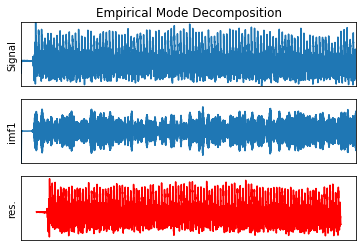

In [ ]:
decomposerx=pyhht.emd.EMD(target1)
imfsx=decomposerx.decompose()
plot_imfs(target1,imfsx,np.array(A[' TimeStamp (s)']))

In [ ]:
accelx=imfsx[1]

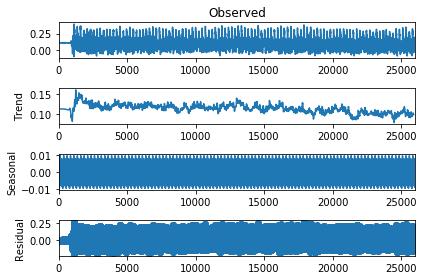

In [ ]:
accelx_decomposed=seasonal_decompose(accelx, model='additive', period=250)
accelx_decomposed.plot()
#plt.xlim(10000,12000)
plt.show()

(10000, 10500)

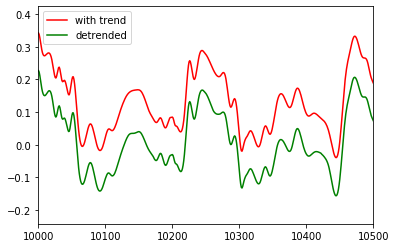

In [ ]:
accelx_filtered=np.array(np.nan_to_num(accelx_decomposed.resid))
plt.plot(accelx,'r', label='with trend')
plt.plot(accelx_filtered, 'g',label='detrended')
plt.legend()
plt.xlim(10000,10500)

In [ ]:
adf_test(accelx_filtered)

Results of dickey fuller test:
test statistics                  -31.016702
p value                            0.000000
#Log used                         47.000000
number of observations used    26000.000000
Critical value (%s) %key          -2.566829
dtype: float64


In [ ]:
kpss_test(accelx_filtered)

results of KPSS test:
test statistics              0.000929
p value                      0.100000
lags used                   49.000000
critical value (%s) %key     0.739000
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [ ]:
U=accely
target1y=np.zeros(len(U))

for i in range(len(U)-1):
    target1y[i]=0.9*target1y[i-1]+0.1*U[i]
    a=target1y[i]
    np.insert(target1y,0,a)

Mode 1, Iteration 600
3 minima > 0; 2305 maxima < 0.
Mode 1, Iteration 800
4 minima > 0; 2380 maxima < 0.
Mode 1, Iteration 1000
3 minima > 0; 2430 maxima < 0.
Mode 1, Iteration 1200
3 minima > 0; 2497 maxima < 0.
Mode 1, Iteration 1400
1 minima > 0; 2562 maxima < 0.
Mode 1, Iteration 1600
1 minima > 0; 2580 maxima < 0.
Mode 1, Iteration 1800
4 minima > 0; 2628 maxima < 0.


C:\ProgramData\Anaconda3\lib\site-packages\pyhht\emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


2


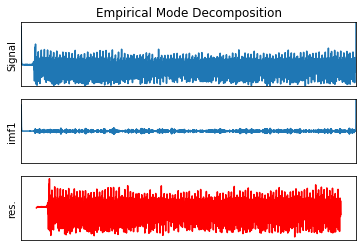

In [ ]:
decomposery=pyhht.emd.EMD(target1y)
imfsy=decomposery.decompose()
plot_imfs(target1y,imfsy,np.array(A[' TimeStamp (s)']))

In [ ]:
accely=imfsy[1]

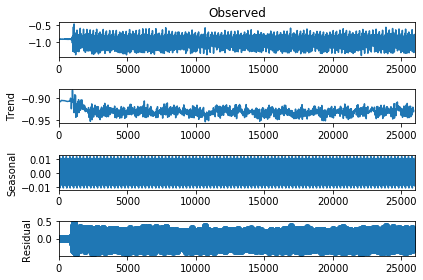

In [ ]:
accely_decomposed=seasonal_decompose(accely, model='additive', period=250)
accely_decomposed.plot()
#plt.xlim(10000,12000)
plt.show()

(10000, 10500)

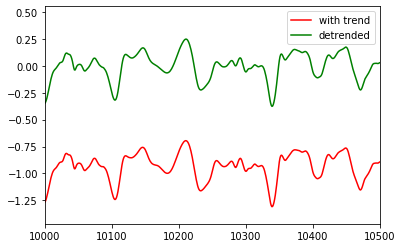

In [ ]:
accely_filtered=np.array(np.nan_to_num(accely_decomposed.resid))
plt.plot(accely,'r', label='with trend')
plt.plot(accely_filtered, 'g',label='detrended')
plt.legend()
plt.xlim(10000,10500)

In [ ]:
adf_test(accely_filtered)

Results of dickey fuller test:
test statistics                  -33.642050
p value                            0.000000
#Log used                         27.000000
number of observations used    26020.000000
Critical value (%s) %key          -2.566829
dtype: float64


In [ ]:
kpss_test(accely_filtered)

results of KPSS test:
test statistics              0.00094
p value                      0.10000
lags used                   49.00000
critical value (%s) %key     0.73900
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [ ]:
U=accelz
target1z=np.zeros(len(U))

for i in range(len(U)-1):
    target1z[i]=0.9*target1z[i-1]+0.1*U[i]
    a=target1z[i]
    np.insert(target1z,0,a)

Mode 1, Iteration 600
4 minima > 0; 4317 maxima < 0.
Mode 1, Iteration 800
6 minima > 0; 4411 maxima < 0.
Mode 1, Iteration 1000
3 minima > 0; 4444 maxima < 0.
Mode 1, Iteration 1200
3 minima > 0; 4500 maxima < 0.
Mode 1, Iteration 1400
4 minima > 0; 4531 maxima < 0.
Mode 1, Iteration 1600
4 minima > 0; 4571 maxima < 0.
Mode 1, Iteration 1800
4 minima > 0; 4598 maxima < 0.


C:\ProgramData\Anaconda3\lib\site-packages\pyhht\emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


2


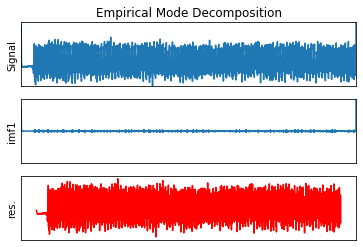

In [ ]:
decomposerz=pyhht.emd.EMD(target1z)
imfsz=decomposerz.decompose()
plot_imfs(target1z,imfsz,np.array(A[' TimeStamp (s)']))

In [ ]:
accelz=imfsz[1]

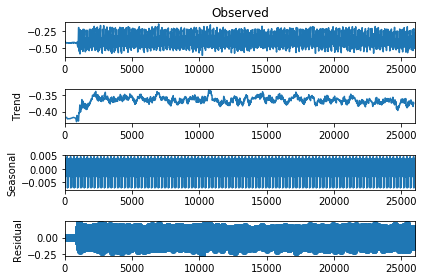

In [ ]:
accelz_decomposed=seasonal_decompose(accelz, model='additive', period=250)
accelz_decomposed.plot()
#plt.xlim(10000,12000)
plt.show()

(10000, 10500)

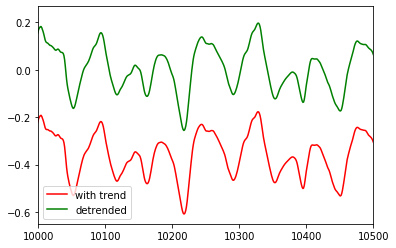

In [ ]:
accelz_filtered=np.array(np.nan_to_num(accelz_decomposed.resid))
plt.plot(accelz,'r', label='with trend')
plt.plot(accelz_filtered, 'g',label='detrended')
plt.legend()
plt.xlim(10000,10500)

In [ ]:
adf_test(accelz_filtered)

Results of dickey fuller test:
test statistics                  -23.015580
p value                            0.000000
#Log used                         45.000000
number of observations used    26002.000000
Critical value (%s) %key          -2.566829
dtype: float64


In [ ]:
kpss_test(accelz_filtered)

results of KPSS test:
test statistics              0.001019
p value                      0.100000
lags used                   49.000000
critical value (%s) %key     0.739000
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [ ]:
U=q1
targetq=np.zeros(len(U))

for i in range(len(U)-1):
    targetq[i]=0.9*targetq[i-1]+0.1*U[i]
    a=targetq[i]
    np.insert(targetq,0,a)

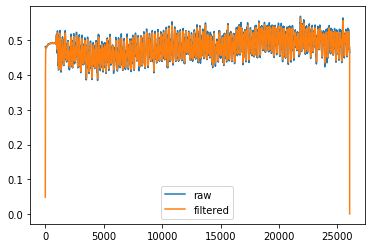

In [ ]:
plt.plot(q1,label='raw')
plt.plot(targetq,label='filtered')
plt.legend()
#plt.xlim(10000,11000)

2
3
4
5
6
7
8
9


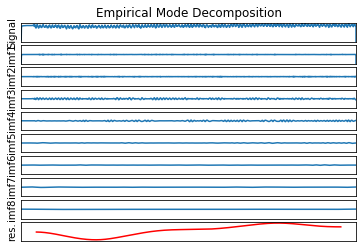

In [ ]:
decomposerq1=pyhht.emd.EMD(targetq)
imfsq1=decomposerq1.decompose()
plot_imfs(targetq,imfsq1,np.array(A[' TimeStamp (s)']))

(10000, 11000)

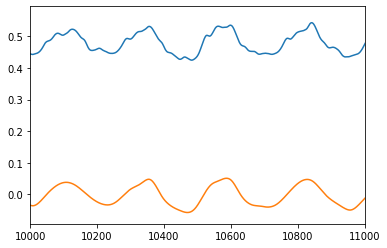

In [ ]:
q1=imfsq1[2]+imfsq1[3]+imfsq1[4]+imfsq1[5]
plt.plot(targetq)
plt.plot(q1)
plt.xlim(10000,11000)

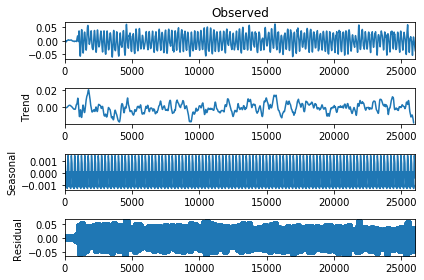

In [ ]:
q1_decomposed=seasonal_decompose(q1, model='additive', period=250)
q1_decomposed.plot()
#plt.xlim(10000,12000)
plt.show()

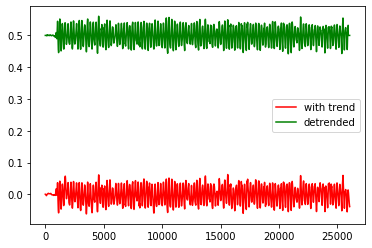

In [ ]:
q1_filtered=np.array(np.nan_to_num(q1_decomposed.resid))+0.5
plt.plot(q1,'r', label='with trend')
plt.plot(q1_filtered, 'g',label='detrended')
plt.legend()
#plt.xlim(10000,10500)

In [ ]:
adf_test(q1_filtered)

Results of dickey fuller test:
test statistics                  -33.932594
p value                            0.000000
#Log used                         49.000000
number of observations used    25998.000000
Critical value (%s) %key          -2.566829
dtype: float64


In [ ]:
kpss_test(q1_filtered)

results of KPSS test:
test statistics              0.001305
p value                      0.100000
lags used                   49.000000
critical value (%s) %key     0.739000
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [ ]:
U=q2
targetq=np.zeros(len(U))

for i in range(len(U)-1):
    targetq[i]=0.9*targetq[i-1]+0.1*U[i]
    a=targetq[i]
    np.insert(targetq,0,a)

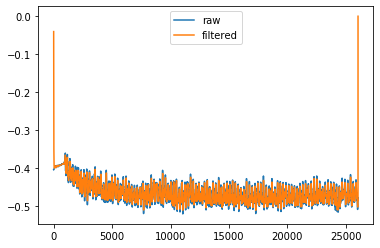

In [ ]:
plt.plot(q2,label='raw')
plt.plot(targetq,label='filtered')
plt.legend()
#plt.xlim(10000,11000)

Mode 1, Iteration 600
4 minima > 0; 1678 maxima < 0.
Mode 1, Iteration 800
2 minima > 0; 1773 maxima < 0.
Mode 2, Iteration 1000
0 minima > 0; 634 maxima < 0.
Mode 4, Iteration 1200
0 minima > 0; 141 maxima < 0.
Mode 5, Iteration 1400
0 minima > 0; 90 maxima < 0.
2
3
4
5
6
7
8
9
10
11


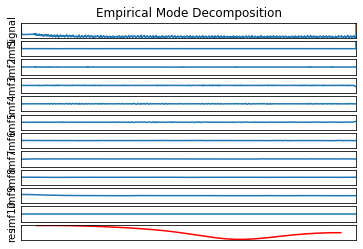

In [ ]:
decomposerq2=pyhht.emd.EMD(targetq)
imfsq2=decomposerq2.decompose()
plot_imfs(targetq,imfsq2,np.array(A[' TimeStamp (s)']))

In [ ]:
q2=imfsq2[2]+imfsq2[3]+imfsq2[4]+imfsq2[5]+imfsq2[6]

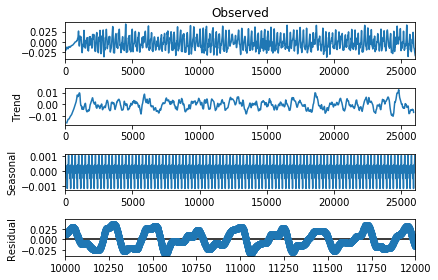

In [ ]:
q2_decomposed=seasonal_decompose(q2, model='additive', period=250)
q2_decomposed.plot()
plt.xlim(10000,12000)
plt.show()

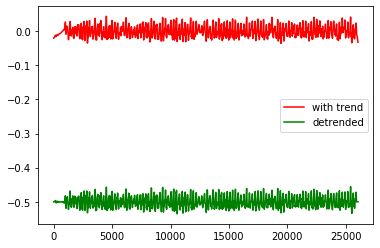

In [ ]:
q2_filtered=np.array(np.nan_to_num(q2_decomposed.resid))-0.5
plt.plot(q2,'r', label='with trend')
plt.plot(q2_filtered, 'g',label='detrended')
plt.legend()
#plt.xlim(10000,10500)

In [ ]:
adf_test(q2_filtered)

Results of dickey fuller test:
test statistics                  -24.917979
p value                            0.000000
#Log used                         49.000000
number of observations used    25998.000000
Critical value (%s) %key          -2.566829
dtype: float64


In [ ]:
kpss_test(q2_filtered)

results of KPSS test:
test statistics              0.001967
p value                      0.100000
lags used                   49.000000
critical value (%s) %key     0.739000
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [ ]:
U=q3
targetq=np.zeros(len(U))

for i in range(len(U)-1):
    targetq[i]=0.9*targetq[i-1]+0.1*U[i]
    a=targetq[i]
    np.insert(targetq,0,a)

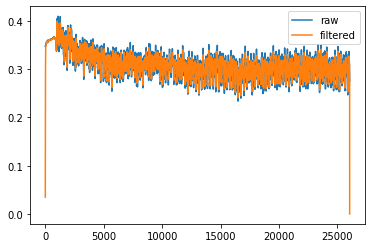

In [ ]:
plt.plot(q3,label='raw')
plt.plot(targetq,label='filtered')
plt.legend()
#plt.xlim(10000,11000)

Mode 1, Iteration 600
2 minima > 0; 1258 maxima < 0.
Mode 1, Iteration 800
5 minima > 0; 1318 maxima < 0.
Mode 1, Iteration 1000
1 minima > 0; 1372 maxima < 0.
Mode 2, Iteration 1200
0 minima > 0; 667 maxima < 0.
2
3
4
5
6
7
8
9
10


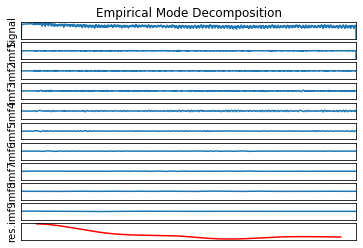

In [ ]:
decomposerq3=pyhht.emd.EMD(targetq)
imfsq3=decomposerq3.decompose()
plot_imfs(targetq,imfsq3,np.array(A[' TimeStamp (s)']))

In [ ]:
q3=imfsq3[2]+imfsq3[3]+imfsq3[4]+imfsq3[5]+imfsq3[6]

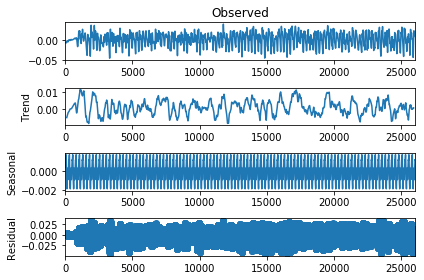

In [ ]:
q3_decomposed=seasonal_decompose(q3, model='additive', period=250)
q3_decomposed.plot()
#plt.xlim(10000,12000)
plt.show()

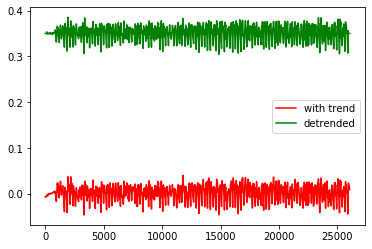

In [ ]:
q3_filtered=np.array(np.nan_to_num(q3_decomposed.resid))+0.35
plt.plot(q3,'r', label='with trend')
plt.plot(q3_filtered, 'g',label='detrended')
plt.legend()
#plt.xlim(10000,10500)

In [ ]:
adf_test(q3_filtered)

Results of dickey fuller test:
test statistics                  -26.348738
p value                            0.000000
#Log used                         49.000000
number of observations used    25998.000000
Critical value (%s) %key          -2.566829
dtype: float64


In [ ]:
kpss_test(q3_filtered)

results of KPSS test:
test statistics              0.003477
p value                      0.100000
lags used                   49.000000
critical value (%s) %key     0.739000
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [ ]:
U=q4
targetq=np.zeros(len(U))

for i in range(len(U)-1):
    targetq[i]=0.9*targetq[i-1]+0.1*U[i]
    a=targetq[i]
    np.insert(targetq,0,a)

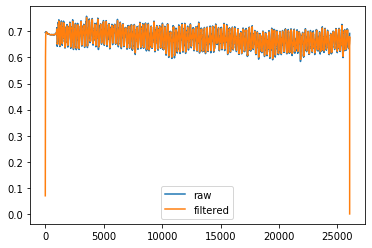

In [ ]:
plt.plot(q4,label='raw')
plt.plot(targetq,label='filtered')
plt.legend()
#plt.xlim(10000,11000)

2
3
4
5
6
7
8
9


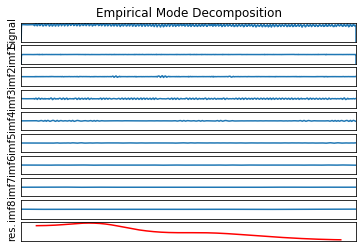

In [ ]:
decomposerq4=pyhht.emd.EMD(targetq)
imfsq4=decomposerq4.decompose()
plot_imfs(targetq,imfsq4,np.array(A[' TimeStamp (s)']))

In [ ]:
q4=imfsq4[2]+imfsq4[3]+imfsq4[4]+imfsq4[5]+imfsq4[6]

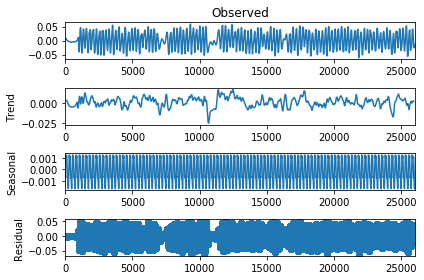

In [ ]:
q4_decomposed=seasonal_decompose(q4, model='additive', period=250)
q4_decomposed.plot()
#plt.xlim(10000,12000)
plt.show()

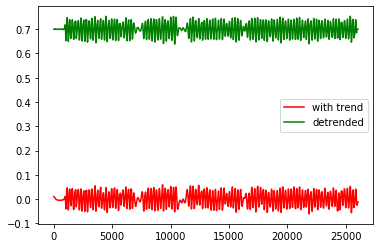

In [ ]:
q4_filtered=np.array(np.nan_to_num(q4_decomposed.resid))+0.7
plt.plot(q4,'r', label='with trend')
plt.plot(q4_filtered, 'g',label='detrended')
plt.legend()
#plt.xlim(10000,10500)

In [ ]:
adf_test(q4_filtered)

Results of dickey fuller test:
test statistics                  -30.931301
p value                            0.000000
#Log used                         49.000000
number of observations used    25998.000000
Critical value (%s) %key          -2.566829
dtype: float64


In [ ]:
kpss_test(q4_filtered)

results of KPSS test:
test statistics              0.001859
p value                      0.100000
lags used                   49.000000
critical value (%s) %key     0.739000
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [ ]:
#Rotation Matrix
#it is possible to construct rotation matrix from quaternion, the relation between each parameter and quaternion is defined and is calculated 
m11=np.power(q1_filtered,2)+np.power(q2_filtered,2)-np.power(q3_filtered,2)-np.power(q4_filtered,2)
m12=2*(np.multiply(q2_filtered,q3_filtered)-np.multiply(q1_filtered,q4_filtered))
m13=2*(np.multiply(q2_filtered,q4_filtered)+np.multiply(q3_filtered,q1_filtered))

m21=2*(np.multiply(q2_filtered,q3_filtered)+np.multiply(q1_filtered,q4_filtered))
m22=np.power(q1_filtered,2)-np.power(q2_filtered,2)+np.power(q3_filtered,2)-np.power(q4_filtered,2)
m23=2*(np.multiply(q3_filtered,q4_filtered)-np.multiply(q2_filtered,q1_filtered))

m31=2*(np.multiply(q2_filtered,q4_filtered)-np.multiply(q3_filtered,q1_filtered))
m32=2*(np.multiply(q3_filtered,q4_filtered)+np.multiply(q2_filtered,q1_filtered))
m33=np.power(q1_filtered,2)-np.power(q2_filtered,2)-np.power(q3_filtered,2)+np.power(q4_filtered,2)

In [ ]:
#multiply rotation matrix by acceleration vector to rotate it to global frame directions 
linaccelx1=np.multiply(m11,accelx_filtered)+np.multiply(m12,accely_filtered)+np.multiply(m13,accelz_filtered)
linaccely1=np.multiply(m21,accelx_filtered)+np.multiply(m22,accely_filtered)+np.multiply(m23,accelz_filtered)
linaccelz1=np.multiply(m31,accelx_filtered)+np.multiply(m32,accely_filtered)+np.multiply(m33,accelz_filtered)

In [ ]:
total_acceleration=np.power((np.power(linaccelx1,2)+np.power(linaccely1,2)+np.power(linaccelz1,2)),0.5)

(10000, 11000)

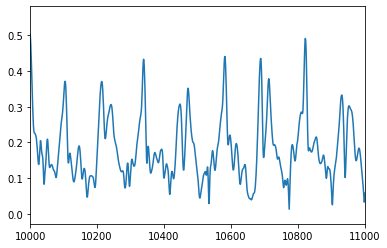

In [ ]:
plt.plot(total_acceleration)
plt.xlim(10000,11000)

(10000, 10500)

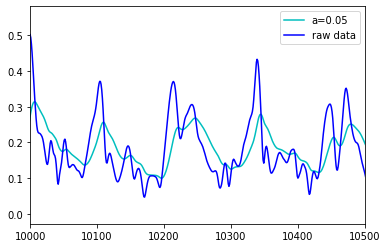

In [ ]:
U=total_acceleration
target1=np.zeros(len(U))

for i in range(len(U)-1):
    target1[i]=0.9*target1[i-1]+0.1*U[i]
    a=target1[i]
    np.insert(target1,0,a)
    
target2=np.zeros(len(U))

for i in range(len(U)-1):
    target2[i]=(1-0.05)*target2[i-1]+0.05*U[i]
    a=target2[i]
    np.insert(target2,0,a)
    
target3=np.zeros(len(U))

for i in range(len(U)-1):
    target3[i]=(1-0.01)*target2[i-1]+0.01*U[i]
    a=target3[i]
    np.insert(target1,0,a)
    
target4=np.zeros(len(U))

for i in range(len(U)-1):
    target4[i]=(1-0.005)*target4[i-1]+0.005*U[i]
    a=target4[i]
    np.insert(target4,0,a)
    
target5=np.zeros(len(U))

for i in range(len(U)-1):
    target5[i]=(1-0.001)*target5[i-1]+0.001*U[i]
    a=target5[i]
    np.insert(target5,0,a)
    
#plt.plot(target1,'r',label='a=0.1')
plt.plot(target2,'c',label='a=0.05')
#plt.plot(target3,'g',label='a=0.01')
#plt.plot(target4,'m',label='a=0.005')
#plt.plot(target5,'y',label='a=0.001')
plt.plot(total_acceleration,'b',label='raw data')
plt.legend()
plt.xlim(10000,10500)

In [ ]:
W=target2
smoothed2=np.zeros(len(W))

for i in range(len(W)-3):
    smoothed2[i]=(W[i-3]-3*W[i-2]+6*W[i-1]+7*W[i]+6*W[i+1]-3*W[i+2]+W[i+3])/27
    k=smoothed2[i]
    np.insert(smoothed2,0,k)

(10200, 10600)

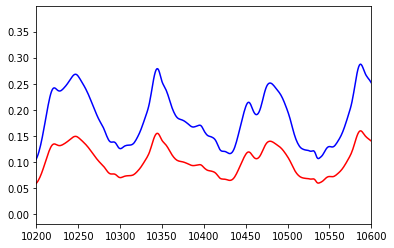

In [ ]:
plt.plot(W,'b')
plt.plot(smoothed2,'r')
plt.xlim(10200,10600)

In [ ]:
e=target2
s1=np.zeros(len(e))

for i in range(len(e)-1):
    s1[i]=(e[i-1]+e[i]+e[i+1])/3
    np.insert(s1,0,s1[i])
    
s2=np.zeros(len(s1))

for i in range(len(s1)-1):
    s2[i]=(s1[i-1]+s1[i]+s1[i+1])/3
    np.insert(s2,0,s2[i])
    
smoothed=np.zeros(len(s2))

for i in range(len(s2)-1):
    smoothed[i]=(s2[i-1]+s2[i]+s2[i+1])/3
    np.insert(smoothed,0,smoothed[i])

(10200, 10600)

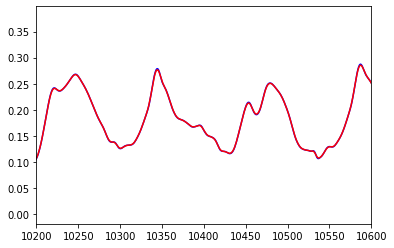

In [ ]:
plt.plot(e,'b')
plt.plot(smoothed,'r')
plt.xlim(10200,10600)

(10000, 12000)

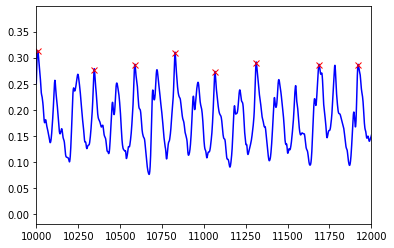

In [ ]:
peaks, _ = signal.find_peaks(smoothed2,distance=200)
plt.plot(target3,'b')
plt.plot(peaks, target3[peaks], "rx")
plt.xlim(10000,12000)

In [ ]:
peaks[61]-peaks[60]

236

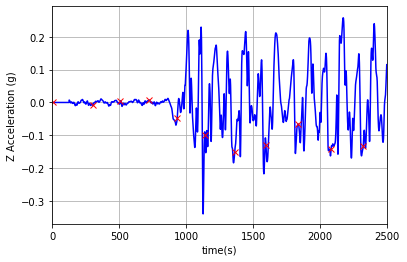

detected cycles abased on the minimums of seasonality [    1   303   508   724   932  1139  1361  1594  1835  2080  2321  2552
  2795  3033  3273  3511  3748  3991  4230  4474  4711  4952  5196  5438
  5677  5918  6160  6395  6632  6875  7122  7360  7603  7843  8077  8321
  8565  8800  9049  9283  9531  9770 10007 10344 10587 10827 11065 11312
 11687 11921 12159 12403 12643 12879 13114 13354 13602 13838 14087 14331
 14573 14809 15147 15513 15757 15997 16232 16475 16716 16961 17204 17444
 17683 17918 18161 18406 18750 19132 19368 19602 19846 20082 20320 20566
 20810 21045 21278 21519 21769 22110 22349 22585 22835 23213 23453 23690
 23930 24172 24412 24648 24892 25132 25369 25603 25843]
(105,)


In [ ]:
plt.plot(linaccelz1,'b')
plt.plot(peaks, linaccelz1[peaks], "rx")
plt.xlabel('time(s)')
plt.ylabel('Z Acceleration (g)')
plt.grid('on')
plt.xlim(0,2500)
plt.show()

print ('detected cycles abased on the minimums of seasonality' , peaks)
n=peaks.shape
print(n)

In [ ]:
peaks[6]

1361

In [ ]:
linaccelz1=linaccelz1[1360:25850]
linaccely1=linaccely1[1360:25850]
linaccelx1=linaccelx1[1360:25850]
smoothed2=smoothed2[1360:25850]
total_acceleration=total_acceleration[1360:25850]

(10000, 12000)

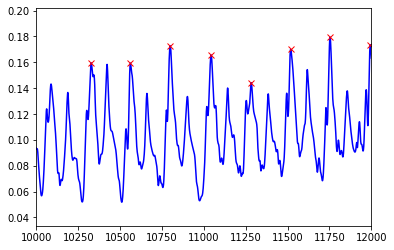

In [ ]:
peaks, _ = signal.find_peaks(smoothed2,distance=200)
plt.plot(smoothed2,'b')
plt.plot(peaks, smoothed2[peaks], "rx")
plt.xlim(10000,12000)

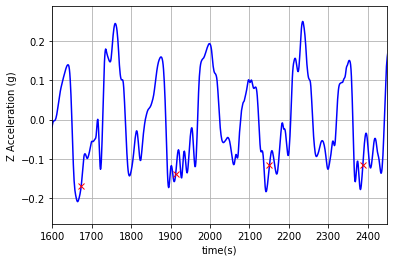

detected cycles abased on the minimums of seasonality [    1   234   475   720   961  1192  1435  1673  1913  2151  2388  2631
  2870  3114  3351  3592  3836  4078  4317  4558  4800  5035  5272  5515
  5762  6000  6243  6483  6717  6961  7205  7440  7689  7923  8171  8410
  8647  8984  9227  9467  9705  9952 10327 10561 10799 11043 11283 11519
 11754 11994 12242 12478 12727 12971 13213 13449 13787 14153 14397 14637
 14872 15115 15356 15601 15844 16084 16323 16558 16801 17046 17390 17772
 18008 18242 18486 18722 18960 19206 19450 19685 19918 20159 20409 20750
 20989 21225 21475 21853 22093 22330 22570 22812 23052 23288 23532 23772
 24009 24243 24483]
(99,)


In [ ]:
plt.plot(linaccelz1,'b')
plt.plot(peaks, linaccelz1[peaks], "rx")
plt.xlabel('time(s)')
plt.ylabel('Z Acceleration (g)')
plt.grid('on')
plt.xlim(1600,2450)
plt.show()

print ('detected cycles abased on the minimums of seasonality' , peaks)
n=peaks.shape
print(n)

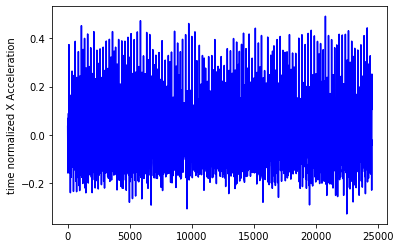

In [ ]:
#start time normalization 
time=np.arange(0,len(linaccelx1),1)
B=[]

for i in range(len(peaks)-1):
    f=sci.interpolate.interp1d(time[peaks[i]:peaks[i+1]],linaccelx1[peaks[i]:peaks[i+1]], fill_value="extrapolate")
    xnew=np.arange(peaks[i],peaks[i+1],(peaks[i+1]-peaks[i])/250)
    cycle=f(xnew)
    B=np.concatenate((B,cycle))
plt.plot(B,'b')
plt.ylabel('time normalized X Acceleration')
plt.show()    


Minima of delayed mutual information from X acceleration  = [13 58 66 78]
Autocorrelation time from X acceleration  = 10


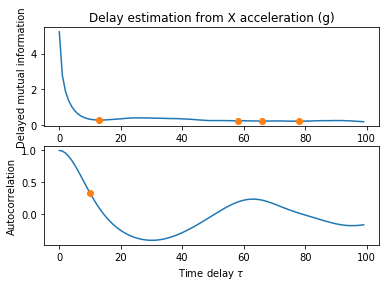

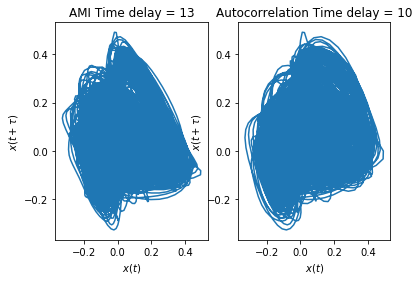

In [ ]:
#now we start processing, first we should fins time lag, two algorithms are suggested 
#autocorrelation as a linear algorithm to find time lag and Average Mutual Information as noninear algorithm 
#a 2D demo description of state space is represented to see the structure 
def localmin(x): 
    return (np.diff(np.sign(np.diff(x)))>0).nonzero()[0]+1
#B=B[peaks[30]:peaks[31]]
lag = np.arange(100)
rx = delay.acorr(B, maxtau=100)
ix = delay.dmi(B, maxtau=100)

i_delayx = localmin(noise.sma(ix, hwin=1)) + 1
r_delayx= np.argmax(rx < 1.0 / np.e)

print(r'Minima of delayed mutual information from X acceleration  = %s' % i_delayx)
print(r'Autocorrelation time from X acceleration  = %d' % r_delayx)

plt.figure(1)

plt.subplot(211)
plt.title(r'Delay estimation from X acceleration (g)')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, ix, i_delayx, ix[i_delayx], 'o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, rx, r_delayx, rx[r_delayx], 'o')

plt.figure(2)
plt.subplot(121)
plt.title(r'AMI Time delay = %d' % i_delayx[0])
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(B[:-i_delayx[0]], B[i_delayx[0]:])

plt.subplot(122)
plt.title(r'Autocorrelation Time delay = %d' % r_delayx)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(B[:-r_delayx], B[r_delayx:])

plt.show()

array([False, False, False, False, False, False,  True,  True,  True,
        True])

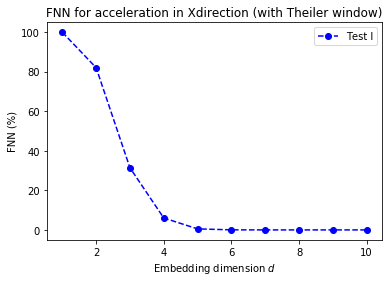

In [ ]:
#run false nearest neighbourhood algorithm to define the dimension 
tau=min(i_delayx)
dim=np.arange(1,10+1)
f1, f2, f3=dimension.fnn(B, tau= tau, dim=dim, window=tau, metric='cityblock')

plt.figure(1)
plt.title(r'FNN for acceleration in Xdirection (with Theiler window)')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
#plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
#plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()
100*f1==0

In [ ]:
edx=100*f1==0
o=0
for i in edx: 
    if i==False:
        o=o+1
    else:
        o+1
    
embedding_dimensionx=o+1
print(embedding_dimensionx)

7


In [ ]:
#calculate entropy
print('permutation entropy, X acceleration:', perm_entropy(B, order=embedding_dimensionx, delay=min(i_delayx), normalize=True))                 # Permutation entropy
print('spectral entropy, x acceleration:', spectral_entropy(B, 100, method='fft', normalize=True)) # Spectral entropy
print('singular value decomposition entrop, x acceleration:',svd_entropy(B, order=embedding_dimensionx, delay=min(i_delayx), normalize=True))         # Singular value decomposition entropy
print('approximate entropy, x acceeration:',app_entropy(B, order=embedding_dimensionx, metric='chebyshev'))              # Approximate entropy
print('sample entropy, x acceleration:',sample_entropy(B, order=embedding_dimensionx, metric='chebyshev'))           # Sample entropy
      

permutation entropy, X acceleration: 0.8447749847785031
spectral entropy, x acceleration: 0.45339630127476094
singular value decomposition entrop, x acceleration: 0.9764011095834101
approximate entropy, x acceeration: 0.28041552306678597
sample entropy, x acceleration: 0.2289841697702325


In [ ]:
#calculate Lyapunov from Rosenstein algorithm 
Lyx=nolds.lyap_r(B, emb_dim=embedding_dimensionx, lag=min(i_delayx),tau=0.01,fit='poly')
print('Maximum Lyapunov Exponent from X Accelarion:', Lyx)

#Lyapunov from Ekman algorithm 
Lyx_e=nolds.lyap_e(B, emb_dim=embedding_dimensionx, matrix_dim=4,  tau=0.01)
print('Lyapunov Eponent from Ekman algorithm, X Acceleration:',Lyx_e)

#compute sample entropy 
SEx=nolds.sampen(B, emb_dim=embedding_dimensionx)
print('Sample Entropy of X Acceleration:', SEx)

#compute Dettrended fluctuation Analysis 
DFAx=nolds.dfa(B,fit_trend='poly',fit_exp='poly')
print('Detrended fluctuation  analysis of X Acceleration;', DFAx)
#compute correlation dimension 

CDx=nolds.corr_dim(B, embedding_dimensionx,fit='poly')
print('Correlation Dimention of X Acceleration:', CDx)

C:\ProgramData\Anaconda3\lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 6125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Maximum Lyapunov Exponent from X Accelarion: 1.7810335195154243
Lyapunov Eponent from Ekman algorithm, X Acceleration: [ 28.340223   9.731217 -10.467493 -50.755413]
Sample Entropy of X Acceleration: 0.22898416977023278
Detrended fluctuation  analysis of X Acceleration; 0.778000340508768
Correlation Dimention of X Acceleration: 2.373200675307806


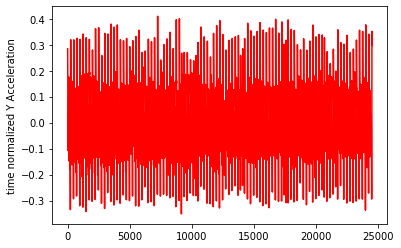

In [ ]:
C=[]

for i in range(len(peaks)-1):
    f=sci.interpolate.interp1d(time[peaks[i]:peaks[i+1]],linaccely1[peaks[i]:peaks[i+1]], fill_value="extrapolate")
    xnew=np.arange(peaks[i],peaks[i+1],(peaks[i+1]-peaks[i])/250)
    cycle=f(xnew)
    C=np.concatenate((C,cycle))
plt.plot(C,'r')
plt.ylabel('time normalized Y Acceleration')
plt.show()

Minima of delayed mutual information from Y acceleration  = [19 45 66]
Autocorrelation time from Y acceleration  = 14


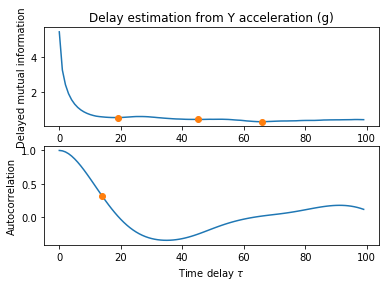

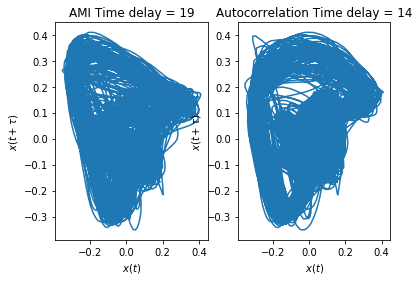

In [ ]:
#C=C[peaks[40]:peaks[41]]
lag = np.arange(100)
ry = delay.acorr(C, maxtau=100)
iy = delay.dmi(C, maxtau=100)

i_delayy = localmin(noise.sma(iy, hwin=1)) + 1
r_delayy= np.argmax(ry < 1.0 / np.e)

print(r'Minima of delayed mutual information from Y acceleration  = %s' % i_delayy)
print(r'Autocorrelation time from Y acceleration  = %d' % r_delayy)

plt.figure(1)

plt.subplot(211)
plt.title(r'Delay estimation from Y acceleration (g)')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, iy, i_delayy, iy[i_delayy], 'o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, ry, r_delayy, ry[r_delayy], 'o')

plt.figure(2)
plt.subplot(121)
plt.title(r'AMI Time delay = %d' % i_delayy[0])
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(C[:-i_delayy[0]], C[i_delayy[0]:])

plt.subplot(122)
plt.title(r'Autocorrelation Time delay = %d' % r_delayy)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(C[:-r_delayy], C[r_delayy:])

plt.show()

array([False, False, False, False, False,  True,  True,  True,  True,
        True])

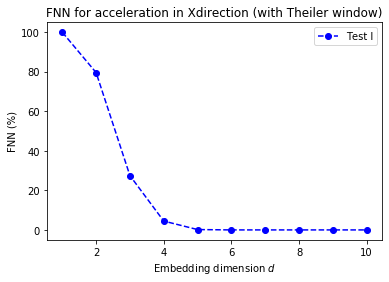

In [ ]:
#run false nearest neighbourhood algorithm to define the dimension 
tau=min(i_delayy)
dim=np.arange(1,10+1)
f1, f2, f3=dimension.fnn(C, tau= tau, dim=dim, window=tau, metric='cityblock')

plt.figure(1)
plt.title(r'FNN for acceleration in Xdirection (with Theiler window)')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
#plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
#plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()
100*f1==0

In [ ]:
edy=100*f1==0
o=0
for i in edy: 
    if i==False:
        o=o+1
    else:
        o+1
    
embedding_dimensiony=o+1
print(embedding_dimensiony)

6


In [ ]:
#calculate entropy
print('permutation entropy, X acceleration:', perm_entropy(C, order=embedding_dimensiony, delay=min(i_delayy), normalize=True))                 # Permutation entropy
print('spectral entropy, x acceleration:', spectral_entropy(C, 100, method='fft', normalize=True)) # Spectral entropy
print('singular value decomposition entrop, x acceleration:',svd_entropy(C, order=embedding_dimensiony, delay=min(i_delayy), normalize=True))         # Singular value decomposition entropy
print('approximate entropy, x acceeration:',app_entropy(C, order=embedding_dimensiony, metric='chebyshev'))              # Approximate entropy
print('sample entropy, x acceleration:',sample_entropy(C, order=embedding_dimensiony, metric='chebyshev'))           # Sample entropy
      

permutation entropy, X acceleration: 0.8375306627477623
spectral entropy, x acceleration: 0.3829670397419385
singular value decomposition entrop, x acceleration: 0.9879341953094583
approximate entropy, x acceeration: 0.2082035927218593
sample entropy, x acceleration: 0.1868870613212692


In [ ]:
#calculate Lyapunov from Rosenstein algorithm 
Lyy=nolds.lyap_r(C, emb_dim=embedding_dimensiony, lag=min(i_delayy),tau=0.01,fit='poly')
print('Maximum Lyapunov Exponent from Y Accelarion:', Lyy)

#compute sample entropy 
SEy=nolds.sampen(C, emb_dim=embedding_dimensiony)
print('Sample Entropy of Y Acceleration:', SEy)

#compute Dettrended fluctuation Analysis 
DFAy=nolds.dfa(C,fit_trend='poly',fit_exp='poly')
print('Detrended fluctuation  analysis of Y Acceleration;', DFAy)
#compute correlation dimension 

CDy=nolds.corr_dim(C, embedding_dimensiony,fit='poly')
print('Correlation Dimention of Y Acceleration:', CDy)

C:\ProgramData\Anaconda3\lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 6125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Maximum Lyapunov Exponent from Y Accelarion: 1.4513930880037458
Sample Entropy of Y Acceleration: 0.1868870613212692
Detrended fluctuation  analysis of Y Acceleration; 0.9254578975715214
Correlation Dimention of Y Acceleration: 2.0299832217573086


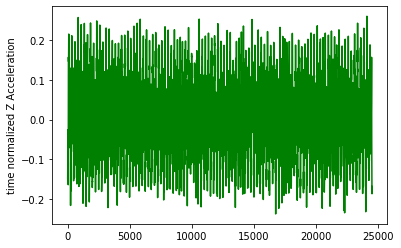

In [ ]:
D=[]

for i in range(len(peaks)-1):
    f=sci.interpolate.interp1d(time[peaks[i]:peaks[i+1]],linaccelz1[peaks[i]:peaks[i+1]], fill_value="extrapolate")
    xnew=np.arange(peaks[i],peaks[i+1],(peaks[i+1]-peaks[i])/250)
    cycle=f(xnew)
    D=np.concatenate((D,cycle))
plt.plot(D,'g')
plt.ylabel('time normalized Z Acceleration')
plt.show()

Minima of delayed mutual information from Z acceleration  = [30 77 94]
Autocorrelation time from Z acceleration  = 22


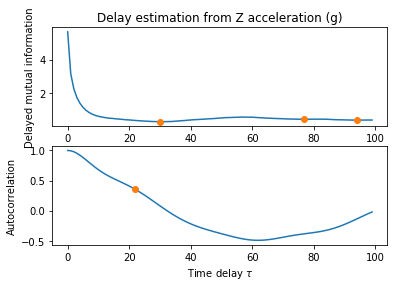

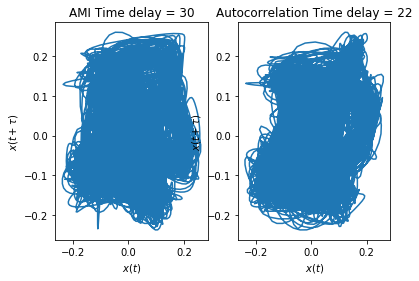

In [ ]:
#D=D[peaks[50]:peaks[51]]
lag = np.arange(100)
rz = delay.acorr(D, maxtau=100)
iz = delay.dmi(D, maxtau=100)

i_delayz = localmin(noise.sma(iz, hwin=1)) + 1
r_delayz= np.argmax(rz < 1.0 / np.e)

print(r'Minima of delayed mutual information from Z acceleration  = %s' % i_delayz)
print(r'Autocorrelation time from Z acceleration  = %d' % r_delayz)

plt.figure(1)

plt.subplot(211)
plt.title(r'Delay estimation from Z acceleration (g)')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, iz, i_delayz, iz[i_delayz], 'o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, rz, r_delayz, rz[r_delayz], 'o')

plt.figure(2)
plt.subplot(121)
plt.title(r'AMI Time delay = %d' % i_delayz[0])
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(D[:-i_delayz[0]], D[i_delayz[0]:])

plt.subplot(122)
plt.title(r'Autocorrelation Time delay = %d' % r_delayz)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(D[:-r_delayz], D[r_delayz:])

plt.show()

array([False, False, False, False, False, False,  True,  True,  True,
        True])

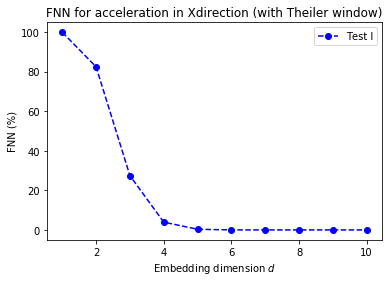

In [ ]:
#run false nearest neighbourhood algorithm to define the dimension 
tau=min(i_delayz)
dim=np.arange(1,10+1)
f1, f2, f3=dimension.fnn(D, tau= tau, dim=dim, window=tau, metric='cityblock')

plt.figure(1)
plt.title(r'FNN for acceleration in Xdirection (with Theiler window)')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
#plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
#plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()
100*f1==0

In [ ]:
edz=100*f1==0
o=0
for i in edz: 
    if i==False:
        o=o+1
    else:
        o+1
    
embedding_dimensionz=o+1
print(embedding_dimensionz)

7


In [ ]:
#calculate entropy
print('permutation entropy, Z acceleration:', perm_entropy(D, order=embedding_dimensionz, delay=min(i_delayz), normalize=True))                 # Permutation entropy
print('spectral entropy, Z acceleration:', spectral_entropy(D, 100, method='fft', normalize=True)) # Spectral entropy
print('singular value decomposition entrop, Z acceleration:',svd_entropy(D, order=embedding_dimensionz, delay=min(i_delayz), normalize=True))         # Singular value decomposition entropy
print('approximate entropy, Z acceeration:',app_entropy(D, order=embedding_dimensionz, metric='chebyshev'))              # Approximate entropy
print('sample entropy, Z acceleration:',sample_entropy(D, order=embedding_dimensionz, metric='chebyshev'))           # Sample entropy
      

permutation entropy, Z acceleration: 0.7643179292568256
spectral entropy, Z acceleration: 0.3823644309306275
singular value decomposition entrop, Z acceleration: 0.9634238589378484
approximate entropy, Z acceeration: 0.2833277166710024
sample entropy, Z acceleration: 0.24327399437337704


In [ ]:
#calculate Lyapunov from Rosenstein algorithm 
Lyz=nolds.lyap_r(D, emb_dim=embedding_dimensionz, lag=min(i_delayz),tau=0.01,fit='poly')
print('Maximum Lyapunov Exponent from Z Accelarion:', Lyz)

#compute sample entropy 
SEz=nolds.sampen(D, emb_dim=embedding_dimensionz)
print('Sample Entropy of Z Acceleration:', SEz)

#compute Dettrended fluctuation Analysis 
DFAz=nolds.dfa(D,fit_trend='poly',fit_exp='poly')
print('Detrended fluctuation  analysis of Z Acceleration;', DFAz)
#compute correlation dimension 

CDz=nolds.corr_dim(D, embedding_dimensionz,fit='poly')
print('Correlation Dimention of Z Acceleration:', CDz)

C:\ProgramData\Anaconda3\lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 6125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Maximum Lyapunov Exponent from Z Accelarion: 4.291706721585496
Sample Entropy of Z Acceleration: 0.24327399437337718
Detrended fluctuation  analysis of Z Acceleration; 0.988256402935807
Correlation Dimention of Z Acceleration: 2.449366988383442


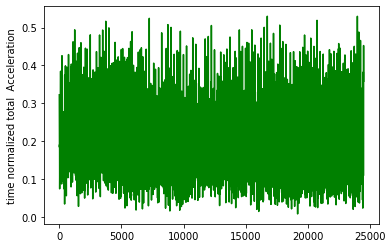

In [ ]:
E=[]

for i in range(len(peaks)-1):
    f=sci.interpolate.interp1d(time[peaks[i]:peaks[i+1]],total_acceleration[peaks[i]:peaks[i+1]], fill_value="extrapolate")
    xnew=np.arange(peaks[i],peaks[i+1],(peaks[i+1]-peaks[i])/250)
    cycle=f(xnew)
    E=np.concatenate((E,cycle))
plt.plot(E,'g')
plt.ylabel('time normalized total  Acceleration')
plt.show()

Minima of delayed mutual information from total acceleration  = [ 29  76  80  97  99 101 121 130 149 158 172 174 176 181 219 229 272 281
 325 332 349 352 370 381 398 405 408 419 426 431 433 470 478 522 531 570
 576 581 584 600 620 631 653 655 668 676 685 692 717 719 729 773 783 823
 830 834 846 851 868 880 899 905 918 926 935 968 972 977]
Autocorrelation time from total acceleration  = 11


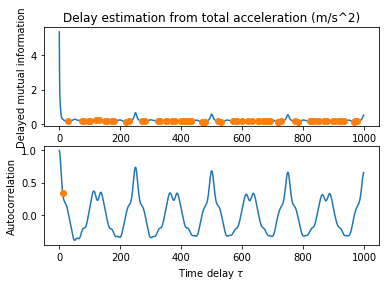

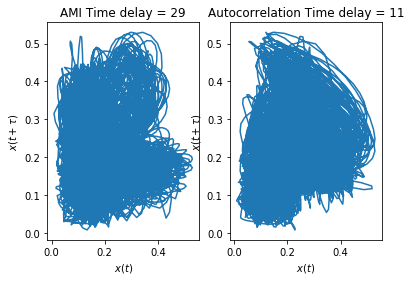

In [ ]:
lag = np.arange(1000)
rtotalaccel = delay.acorr(E, maxtau=1000)
itotalaccel = delay.dmi(E, maxtau=1000)

i_delaytotalaccel = localmin(noise.sma(itotalaccel, hwin=1)) + 1
r_delaytotalaccel= np.argmax(rtotalaccel < 1.0 / np.e)

print(r'Minima of delayed mutual information from total acceleration  = %s' % i_delaytotalaccel)
print(r'Autocorrelation time from total acceleration  = %d' % r_delaytotalaccel)

plt.figure(1)

plt.subplot(211)
plt.title(r'Delay estimation from total acceleration (m/s^2)')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, itotalaccel, i_delaytotalaccel, itotalaccel[i_delaytotalaccel], 'o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, rtotalaccel, r_delaytotalaccel, rtotalaccel[r_delaytotalaccel], 'o')

plt.figure(2)
plt.subplot(121)
plt.title(r'AMI Time delay = %d' % i_delaytotalaccel[0])
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(E[:-i_delaytotalaccel[0]], E[i_delaytotalaccel[0]:])

plt.subplot(122)
plt.title(r'Autocorrelation Time delay = %d' % r_delaytotalaccel)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(E[:-r_delaytotalaccel], E[r_delaytotalaccel:])

plt.show()

array([False, False, False, False, False, False,  True,  True,  True,
        True])

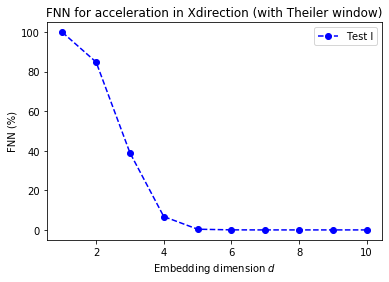

In [ ]:
#run false nearest neighbourhood algorithm to define the dimension 
tau=min(i_delaytotalaccel)
dim=np.arange(1,10+1)
f1, f2, f3=dimension.fnn(E, tau= tau, dim=dim, window=tau, metric='cityblock')

plt.figure(1)
plt.title(r'FNN for acceleration in Xdirection (with Theiler window)')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
#plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
#plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()
100*f1==0

In [ ]:
edta=100*f1==0
o=0
for i in edta: 
    if i==False:
        o=o+1
    else:
        o+1
    
embedding_dimensionta=o+1
print(embedding_dimensionta)

7


In [ ]:
#calculate entropy
print('permutation entropy, total acceleration:', perm_entropy(E, order=embedding_dimensionta, delay=min(i_delaytotalaccel), normalize=True))                 # Permutation entropy
print('spectral entropy, total acceleration:', spectral_entropy(E, 100, method='fft', normalize=True)) # Spectral entropy
print('singular value decomposition entrop, total acceleration:',svd_entropy(E, order=embedding_dimensionta, delay=min(i_delaytotalaccel), normalize=True))         # Singular value decomposition entropy
print('approximate entropy, total acceeration:',app_entropy(E, order=embedding_dimensionta, metric='chebyshev'))              # Approximate entropy
print('sample entropy, totalgh acceleration:',sample_entropy(E, order=embedding_dimensionta, metric='chebyshev'))           # Sample entropy
      

permutation entropy, total acceleration: 0.8871057649933463
spectral entropy, total acceleration: 0.4274111249623471
singular value decomposition entrop, total acceleration: 0.8163608302194497
approximate entropy, total acceeration: 0.36725978919239743
sample entropy, totalgh acceleration: 0.30164559217581005


In [ ]:
#calculate Lyapunov from Rosenstein algorithm 
Lytotalaccel=nolds.lyap_r(E, emb_dim=embedding_dimensionta, lag=min(i_delaytotalaccel),tau=0.01,fit='poly')
print('Maximum Lyapunov Exponent from total Accelarion:', Lytotalaccel)

#compute sample entropy 
SEtotalaccel=nolds.sampen(E, emb_dim=embedding_dimensionta)
print('Sample Entropy of total Acceleration:', SEtotalaccel)

#compute Dettrended fluctuation Analysis 
DFAtotalaccel=nolds.dfa(E,fit_trend='poly',fit_exp='poly')
print('Detrended fluctuation  analysis of total Acceleration;', DFAtotalaccel)
#compute correlation dimension 

CDtotalaccel=nolds.corr_dim(E, embedding_dimensionta,fit='poly')
print('Correlation Dimention of total Acceleration:', CDtotalaccel)

C:\ProgramData\Anaconda3\lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 6125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Maximum Lyapunov Exponent from total Accelarion: 4.183390723135238
Sample Entropy of total Acceleration: 0.3016455921758099
Detrended fluctuation  analysis of total Acceleration; 0.8660242864333108
Correlation Dimention of total Acceleration: 2.684626623728036


In [ ]:
#represent an average cycle 
L=[]
for i in range(0,250):
    i=np.mean(linaccelx1[peaks[30:50]+i])
    L.append(i)

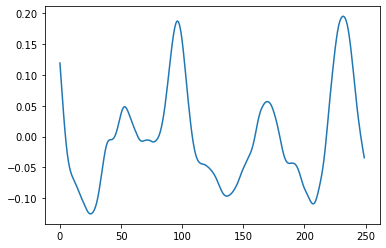

In [ ]:
plt.plot(L)

Minima of delayed mutual information from X acceleration  = [ 9 13 22 29 35 39 58 81 85 97]
Autocorrelation time from X acceleration  = 12


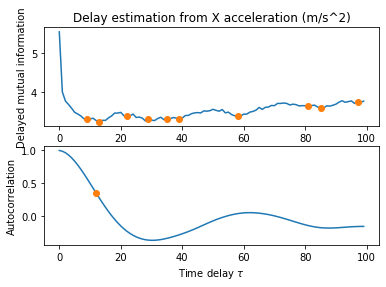

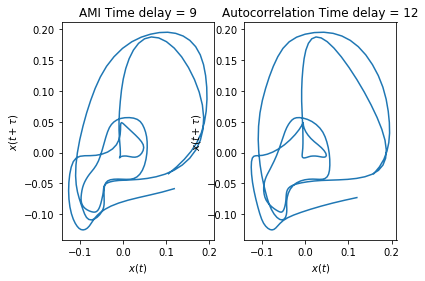

In [ ]:
lag = np.arange(100)
rLx = delay.acorr(L, maxtau=100)
iLx = delay.dmi(L, maxtau=100)

i_delayLx = localmin(noise.sma(iLx, hwin=1)) + 1
r_delayLx= np.argmax(rLx < 1.0 / np.e)

print(r'Minima of delayed mutual information from X acceleration  = %s' % i_delayLx)
print(r'Autocorrelation time from X acceleration  = %d' % r_delayLx)

plt.figure(1)

plt.subplot(211)
plt.title(r'Delay estimation from X acceleration (m/s^2)')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, iLx, i_delayLx, iLx[i_delayLx], 'o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, rLx, r_delayLx, rLx[r_delayLx], 'o')

plt.figure(2)
plt.subplot(121)
plt.title(r'AMI Time delay = %d' % i_delayLx[0])
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(L[:-i_delayLx[0]], L[i_delayLx[0]:])

plt.subplot(122)
plt.title(r'Autocorrelation Time delay = %d' % r_delayLx)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(L[:-r_delayLx], L[r_delayLx:])

plt.show()

In [ ]:
M=[]
for i in range(0,250):
    i=np.mean(linaccely1[peaks[30:50]+i])
    M.append(i)

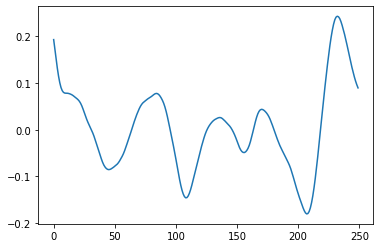

In [ ]:
plt.plot(M)

Minima of delayed mutual information from Y acceleration  = [14 17 23 29 44 55 68 75 80 84 93]
Autocorrelation time from Y acceleration  = 13


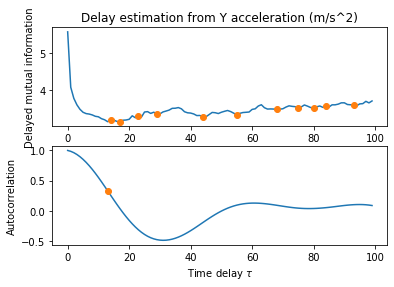

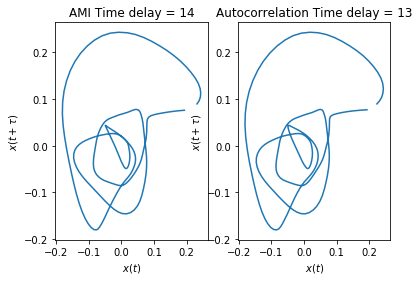

In [ ]:
lag = np.arange(100)
rMx = delay.acorr(M, maxtau=100)
iMx = delay.dmi(M, maxtau=100)

i_delayMx = localmin(noise.sma(iMx, hwin=1)) + 1
r_delayMx= np.argmax(rMx < 1.0 / np.e)

print(r'Minima of delayed mutual information from Y acceleration  = %s' % i_delayMx)
print(r'Autocorrelation time from Y acceleration  = %d' % r_delayMx)

plt.figure(1)

plt.subplot(211)
plt.title(r'Delay estimation from Y acceleration (m/s^2)')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, iMx, i_delayMx, iMx[i_delayMx], 'o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, rMx, r_delayMx, rMx[r_delayMx], 'o')

plt.figure(2)
plt.subplot(121)
plt.title(r'AMI Time delay = %d' % i_delayMx[0])
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(M[:-i_delayMx[0]], M[i_delayMx[0]:])

plt.subplot(122)
plt.title(r'Autocorrelation Time delay = %d' % r_delayMx)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(M[:-r_delayMx], M[r_delayMx:])

plt.show()

In [ ]:
N=[]
for i in range(0,250):
    i=np.mean(linaccelz1[peaks[50:55]+i])
    N.append(i)

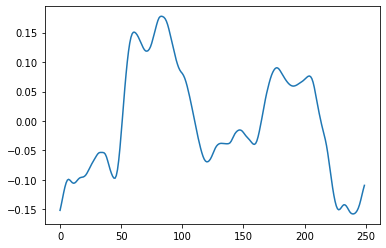

In [ ]:
plt.plot(N)

Minima of delayed mutual information from Z acceleration  = [ 7  9 19 25 29 42 47 54 57 59 61 66 80 83 90]
Autocorrelation time from Z acceleration  = 20


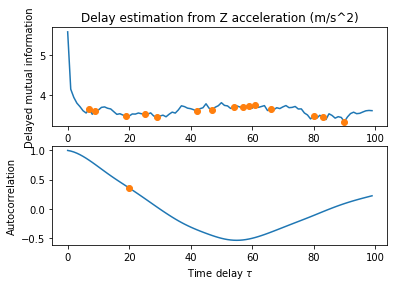

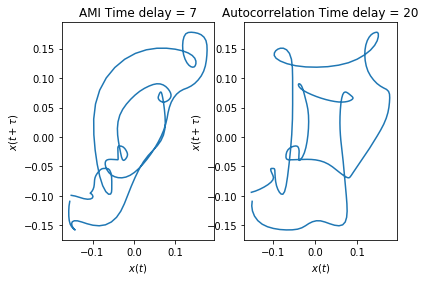

In [ ]:
lag = np.arange(100)
rNx = delay.acorr(N, maxtau=100)
iNx = delay.dmi(N, maxtau=100)

i_delayNx = localmin(noise.sma(iNx, hwin=1)) + 1
r_delayNx= np.argmax(rNx < 1.0 / np.e)

print(r'Minima of delayed mutual information from Z acceleration  = %s' % i_delayNx)
print(r'Autocorrelation time from Z acceleration  = %d' % r_delayNx)

plt.figure(1)

plt.subplot(211)
plt.title(r'Delay estimation from Z acceleration (m/s^2)')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, iNx, i_delayNx, iNx[i_delayNx], 'o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, rNx, r_delayNx, rNx[r_delayNx], 'o')

plt.figure(2)
plt.subplot(121)
plt.title(r'AMI Time delay = %d' % i_delayNx[0])
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(N[:-i_delayNx[0]], N[i_delayNx[0]:])

plt.subplot(122)
plt.title(r'Autocorrelation Time delay = %d' % r_delayNx)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(N[:-r_delayNx], N[r_delayNx:])

plt.show()

In [ ]:
jerkx=np.gradient(linaccelx1,0.01)
jerky=np.gradient(linaccely1,0.01)
jerkz=np.gradient(linaccelz1,0.01)

(99,)

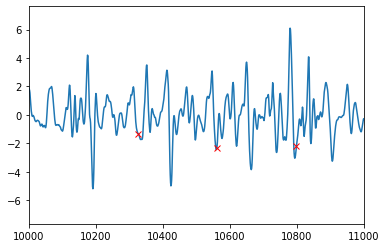

In [ ]:
plt.plot(jerkx)
plt.xlim(10000,11000)

#peaks1,_=sci.signal.find_peaks(jerkx, distance=200)
plt.plot(peaks,jerkx[peaks],'rx')
peaks.shape

plt.plot(linaccelz1)
plt.plot(peaks1[:-10],linaccelz1[peaks1[:-10]],'rx')
plt.xlim(10000,11000)

(10000, 11000)

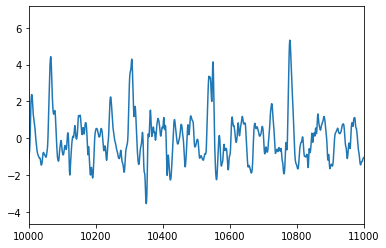

In [ ]:
plt.plot(jerky)
plt.xlim(10000,11000)

(10000, 11000)

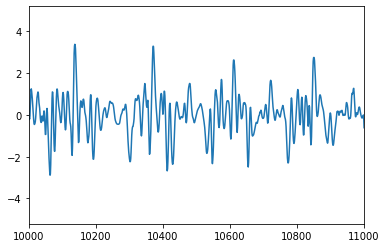

In [ ]:
plt.plot(jerkz)
plt.xlim(10000,11000)

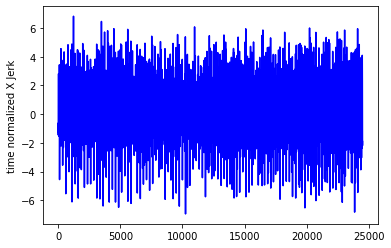

In [ ]:
#start time normalization 
time=np.arange(0,len(jerkx),1)
F=[]

for i in range(len(peaks)-1):
    f=sci.interpolate.interp1d(time[peaks[i]:peaks[i+1]],jerkx[peaks[i]:peaks[i+1]], fill_value="extrapolate")
    xnew=np.arange(peaks[i],peaks[i+1],(peaks[i+1]-peaks[i])/250)
    cycle=f(xnew)
    F=np.concatenate((F,cycle))
plt.plot(F,'b')
plt.ylabel('time normalized X Jerk')
plt.show()  

Minima of delayed mutual information from X Jerk  = [  8  25  39  52  72  82 107 121 123 125 130 143 169 178 198 226 241 260
 274 302 322 324 331 356 372 381 396 406 408 418 429 448 468 478 490 510
 522 552 572 580 606 620 629 645 668 676 679 699 719 727 740 760 803 823
 832 855 867 874 882 894 917 925 927 929 948 950 963 971 973 991]
Autocorrelation time from X jerk  = 6


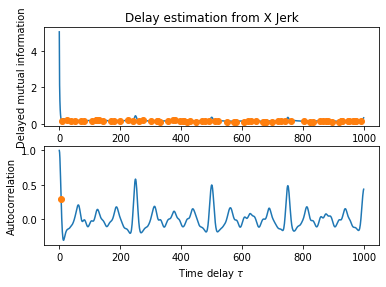

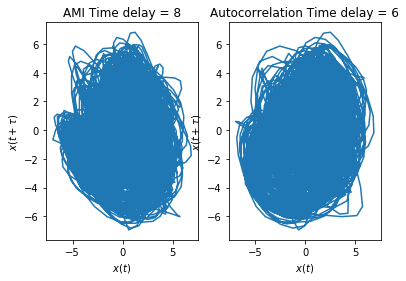

In [ ]:
lag = np.arange(1000)
rjx = delay.acorr(F, maxtau=1000)
ijx = delay.dmi(F, maxtau=1000)

i_delayjx = localmin(noise.sma(ijx, hwin=1)) + 1
r_delayjx= np.argmax(rjx < 1.0 / np.e)

print(r'Minima of delayed mutual information from X Jerk  = %s' % i_delayjx)
print(r'Autocorrelation time from X jerk  = %d' % r_delayjx)

plt.figure(1)

plt.subplot(211)
plt.title(r'Delay estimation from X Jerk')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, ijx, i_delayjx, ijx[i_delayjx], 'o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, rjx, r_delayjx, rjx[r_delayjx], 'o')

plt.figure(2)
plt.subplot(121)
plt.title(r'AMI Time delay = %d' % i_delayjx[0])
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(F[:-i_delayjx[0]], F[i_delayjx[0]:])

plt.subplot(122)
plt.title(r'Autocorrelation Time delay = %d' % r_delayjx)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(F[:-r_delayjx], F[r_delayjx:])

plt.show()

[False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[False False False False False False False False False False False False
 False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False]


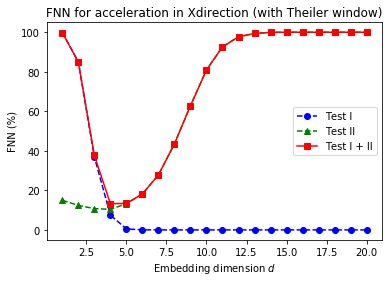

In [ ]:
#run false nearest neighbourhood algorithm to define the dimension 
tau=min(i_delayjx)
dim=np.arange(1,20+1)
f1, f2, f3=dimension.fnn(F, tau= tau, dim=dim, window=tau, metric='cityblock',maxnum=1000)

plt.figure(1)
plt.title(r'FNN for acceleration in Xdirection (with Theiler window)')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()
print(100*f1==0)
print(100*f2==0)
print(100*f3==0)

In [ ]:
edjx=100*f1==0
o=0
for i in edjx: 
    if i==False:
        o=o+1
    else:
        o+1
    
embedding_dimensionjx=o+1
print(embedding_dimensionjx)

7


In [ ]:
#calculate entropy
print('permutation entropy, X jerk:', perm_entropy(F, order=embedding_dimensionjx, delay=min(i_delayjx), normalize=True))                 # Permutation entropy
print('spectral entropy, X jerk:', spectral_entropy(F, 100, method='fft', normalize=True)) # Spectral entropy
print('singular value decomposition entrop, X jerk:',svd_entropy(F, order=embedding_dimensionjx, delay=min(i_delayjx), normalize=True))         # Singular value decomposition entropy
print('approximate entropy, X jerk:',app_entropy(F, order=embedding_dimensionjx, metric='chebyshev'))              # Approximate entropy
print('sample entropy, X jerk:',sample_entropy(F, order=embedding_dimensionjx, metric='chebyshev'))           # Sample entropy
      

permutation entropy, X jerk: 0.9087125218757865
spectral entropy, X jerk: 0.5895482402951016
singular value decomposition entrop, X jerk: 0.9822675936283033
approximate entropy, X jerk: 0.4253314434548301
sample entropy, X jerk: 0.34107456423493077


In [ ]:
#calculate Lyapunov from Rosenstein algorithm 
Lyjx=nolds.lyap_r(F, emb_dim=embedding_dimensionjx, lag=min(i_delayjx),tau=0.01,fit='poly')
print('Maximum Lyapunov Exponent from X jerk:', Lyjx)

#compute sample entropy 
SEjx=nolds.sampen(F, emb_dim=embedding_dimensionjx)
print('Sample Entropy of X jerk:', SEjx)

#compute Dettrended fluctuation Analysis 
DFAjx=nolds.dfa(F,fit_trend='poly',fit_exp='poly')
print('Detrended fluctuation  analysis of X jerk;', DFAjx)
#compute correlation dimension 

CDjx=nolds.corr_dim(F, embedding_dimensionjx,fit='poly')
print('Correlation Dimention of X jerk:', CDjx)

C:\ProgramData\Anaconda3\lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 6125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Maximum Lyapunov Exponent from X jerk: 2.4468208813017482
Sample Entropy of X jerk: 0.34107456423493043
Detrended fluctuation  analysis of X jerk; 0.5679006034797253
Correlation Dimention of X jerk: 2.844588232444613


In [ ]:
#root man square 
RMSjx= np.power(((np.power(F,2))/F.shape), 0.5)
print('root mean square of X jerk:', RMSjx)

root mean square of X jerk: [0.00660137 0.00570383 0.00485919 ... 0.01388175 0.01321558 0.01219985]


In [ ]:
print('mean of RMS X jerk:',np.mean(RMSjx))
print('standard deviation of RMS X jerk:',np.std(RMSjx))
print('variance of RMS X jerk:',np.var(RMSjx))

mean of RMS X jerk: 0.008650725853036072
standard deviation of RMS X jerk: 0.007692341291316622
variance of RMS X jerk: 5.917211454209467e-05


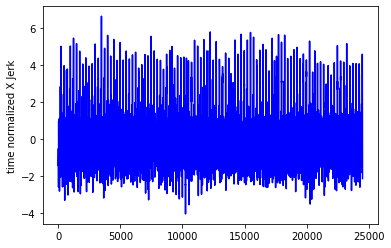

In [ ]:
#start time normalization 
time=np.arange(0,len(jerky),1)
G=[]

for i in range(len(peaks)-1):
    f=sci.interpolate.interp1d(time[peaks[i]:peaks[i+1]],jerky[peaks[i]:peaks[i+1]], fill_value="extrapolate")
    xnew=np.arange(peaks[i],peaks[i+1],(peaks[i+1]-peaks[i])/250)
    cycle=f(xnew)
    G=np.concatenate((G,cycle))
plt.plot(G,'b')
plt.ylabel('time normalized X Jerk')
plt.show()  

Minima of delayed mutual information from Y Jerk  = [ 15  47  64  72  74  80 112 139 171 180 185 204 235 265 297 315 319 331
 362 388 421 432 434 454 468 485 515 546 568 581 612 638 670 680 694 696
 704 719 736 765 797 816 820 822 829 862 888 921 928 934 955 970 972 986]
Autocorrelation time from Y jerk  = 8


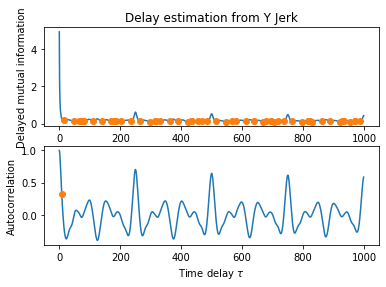

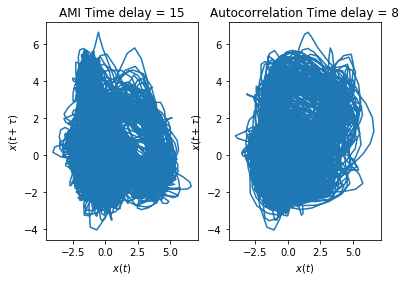

In [ ]:
lag = np.arange(1000)
rjy = delay.acorr(G, maxtau=1000)
ijy = delay.dmi(G, maxtau=1000)

i_delayjy = localmin(noise.sma(ijy, hwin=1)) + 1
r_delayjy= np.argmax(rjy < 1.0 / np.e)

print(r'Minima of delayed mutual information from Y Jerk  = %s' % i_delayjy)
print(r'Autocorrelation time from Y jerk  = %d' % r_delayjy)

plt.figure(1)

plt.subplot(211)
plt.title(r'Delay estimation from Y Jerk')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, ijy, i_delayjy, ijy[i_delayjy], 'o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, rjy, r_delayjy, rjy[r_delayjy], 'o')

plt.figure(2)
plt.subplot(121)
plt.title(r'AMI Time delay = %d' % i_delayjy[0])
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(G[:-i_delayjy[0]], G[i_delayjy[0]:])

plt.subplot(122)
plt.title(r'Autocorrelation Time delay = %d' % r_delayjy)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(G[:-r_delayjy], G[r_delayjy:])

plt.show()

[False False False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[False False False False False False False False False False False False
 False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False]


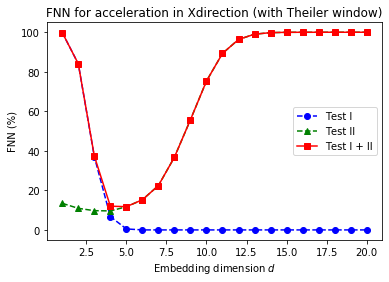

In [ ]:
#run false nearest neighbourhood algorithm to define the dimension 
tau=min(i_delayjy)
dim=np.arange(1,20+1)
f1, f2, f3=dimension.fnn(G, tau= tau, dim=dim, window=tau, metric='cityblock',maxnum=1000)

plt.figure(1)
plt.title(r'FNN for acceleration in Xdirection (with Theiler window)')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()
print(100*f1==0)
print(100*f2==0)
print(100*f3==0)

In [ ]:
edjy=100*f1==0
o=0
for i in edjy: 
    if i==False:
        o=o+1
    else:
        o+1
    
embedding_dimensionjy=o+1
print(embedding_dimensionjy)

6


In [ ]:
#calculate entropy
print('permutation entropy, Y jerk:', perm_entropy(G, order=embedding_dimensionjy, delay=min(i_delayjy), normalize=True))                 # Permutation entropy
print('spectral entropy, Y jerk:', spectral_entropy(G, 100, method='fft', normalize=True)) # Spectral entropy
print('singular value decomposition entrop, Y jerk:',svd_entropy(G, order=embedding_dimensionjy, delay=min(i_delayjy), normalize=True))         # Singular value decomposition entropy
print('approximate entropy, Y jerk:',app_entropy(G, order=embedding_dimensionjy, metric='chebyshev'))              # Approximate entropy
print('sample entropy, Y jerk:',sample_entropy(G, order=embedding_dimensionjy, metric='chebyshev'))           # Sample entropy
      

permutation entropy, Y jerk: 0.9561132751272203
spectral entropy, Y jerk: 0.48396123436639216
singular value decomposition entrop, Y jerk: 0.9809781124346574
approximate entropy, Y jerk: 0.48237498697513104
sample entropy, Y jerk: 0.3809902660161654


In [ ]:
#calculate Lyapunov from Rosenstein algorithm 
Lyjy=nolds.lyap_r(G, emb_dim=embedding_dimensionjy, lag=min(i_delayjy),tau=0.01,fit='poly')
print('Maximum Lyapunov Exponent from Y jerk:', Lyjy)

#compute sample entropy 
SEjy=nolds.sampen(G, emb_dim=embedding_dimensionjy)
print('Sample Entropy of Y jerk:', SEjy)

#compute Dettrended fluctuation Analysis 
DFAjy=nolds.dfa(G,fit_trend='poly',fit_exp='poly')
print('Detrended fluctuation  analysis of Y jerk;', DFAjy)
#compute correlation dimension 

CDjy=nolds.corr_dim(G, embedding_dimensionjy,fit='poly')
print('Correlation Dimention of Y jerk:', CDjy)

C:\ProgramData\Anaconda3\lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 6125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Maximum Lyapunov Exponent from Y jerk: 1.3170631481964805
Sample Entropy of Y jerk: 0.3809902660161656
Detrended fluctuation  analysis of Y jerk; 0.6738378230098064
Correlation Dimention of Y jerk: 2.8262668666960225


In [ ]:
#root man square 
RMSjy= np.power(((np.power(G,2))/G.shape), 0.5)
print('root mean square of Y jerk:', RMSjy)

root mean square of Y jerk: [0.0078468  0.00863589 0.00910505 ... 0.0090182  0.01158336 0.01360402]


In [ ]:
print('mean of RMS Y jerk:',np.mean(RMSjy))
print('standard deviation of RMS Y jerk:',np.std(RMSjy))
print('variance of RMS Y jerk:',np.var(RMSjy))

mean of RMS Y jerk: 0.006539225772910141
standard deviation of RMS Y jerk: 0.005740297729753268
variance of RMS Y jerk: 3.2951018026210526e-05


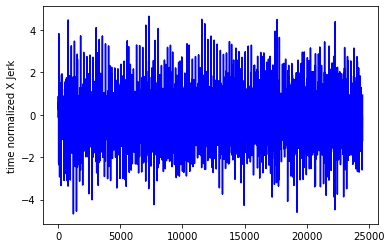

In [ ]:
#start time normalization 
time=np.arange(0,len(jerkz),1)
H=[]

for i in range(len(peaks)-1):
    f=sci.interpolate.interp1d(time[peaks[i]:peaks[i+1]],jerkz[peaks[i]:peaks[i+1]], fill_value="extrapolate")
    xnew=np.arange(peaks[i],peaks[i+1],(peaks[i+1]-peaks[i])/250)
    cycle=f(xnew)
    H=np.concatenate((H,cycle))
plt.plot(H,'b')
plt.ylabel('time normalized X Jerk')
plt.show()  

Minima of delayed mutual information from Z Jerk  = [  7  19  30  49  72  97 116 134 151 178 181 202 220 230 239 263 267 280
 287 299 321 324 348 367 384 402 429 442 452 454 468 478 480 485 518 531
 533 548 569 571 573 575 597 616 635 652 656 679 681 702 712 720 732 734
 763 765 771 784 796 798 824 847 867 883 899 904 925 929 931 950 953 967
 976 980]
Autocorrelation time from Z jerk  = 5


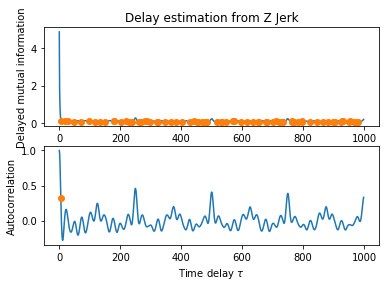

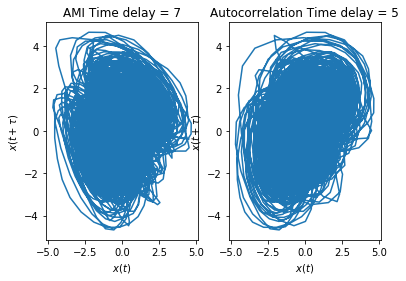

In [ ]:
lag = np.arange(1000)
rjz = delay.acorr(H, maxtau=1000)
ijz = delay.dmi(H, maxtau=1000)

i_delayjz = localmin(noise.sma(ijz, hwin=1)) + 1
r_delayjz= np.argmax(rjz < 1.0 / np.e)

print(r'Minima of delayed mutual information from Z Jerk  = %s' % i_delayjz)
print(r'Autocorrelation time from Z jerk  = %d' % r_delayjz)

plt.figure(1)

plt.subplot(211)
plt.title(r'Delay estimation from Z Jerk')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, ijz, i_delayjz, ijz[i_delayjz], 'o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, rjz, r_delayjz, rjz[r_delayjz], 'o')

plt.figure(2)
plt.subplot(121)
plt.title(r'AMI Time delay = %d' % i_delayjz[0])
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(H[:-i_delayjz[0]], H[i_delayjz[0]:])

plt.subplot(122)
plt.title(r'Autocorrelation Time delay = %d' % r_delayjz)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(H[:-r_delayjz], H[r_delayjz:])

plt.show()

[False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[False False False False False False False False False False False False
 False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False]


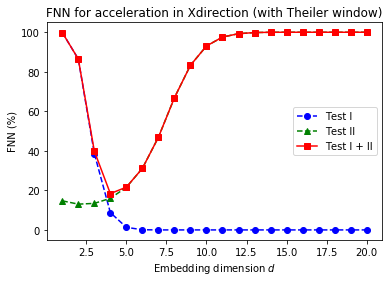

In [ ]:
#run false nearest neighbourhood algorithm to define the dimension 
tau=min(i_delayjz)
dim=np.arange(1,20+1)
f1, f2, f3=dimension.fnn(H, tau= tau, dim=dim, window=tau, metric='cityblock',maxnum=1000)

plt.figure(1)
plt.title(r'FNN for acceleration in Xdirection (with Theiler window)')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()
print(100*f1==0)
print(100*f2==0)
print(100*f3==0)

In [ ]:
edjz=100*f1==0
o=0
for i in edjz: 
    if i==False:
        o=o+1
    else:
        o+1
    
embedding_dimensionjz=o+1
print(embedding_dimensionjz)

7


In [ ]:
#calculate entropy
print('permutation entropy, Z jerk:', perm_entropy(H, order=embedding_dimensionjz, delay=min(i_delayjz), normalize=True))                 # Permutation entropy
print('spectral entropy, Z jerk:', spectral_entropy(H, 100, method='fft', normalize=True)) # Spectral entropy
print('singular value decomposition entrop, Z jerk:',svd_entropy(H, order=embedding_dimensionjz, delay=min(i_delayjz), normalize=True))         # Singular value decomposition entropy
print('approximate entropy, Z jerk:',app_entropy(H, order=embedding_dimensionjz, metric='chebyshev'))              # Approximate entropy
print('sample entropy, Z jerk:',sample_entropy(H, order=embedding_dimensionjz, metric='chebyshev'))           # Sample entropy
      

permutation entropy, Z jerk: 0.9513117644739776
spectral entropy, Z jerk: 0.6405579202240794
singular value decomposition entrop, Z jerk: 0.9945001405367059
approximate entropy, Z jerk: 0.4489279749951409
sample entropy, Z jerk: 0.373826003710169


In [ ]:
#calculate Lyapunov from Rosenstein algorithm 
Lyjz=nolds.lyap_r(H, emb_dim=embedding_dimensionjz, lag=min(i_delayjz),tau=0.01,fit='poly')
print('Maximum Lyapunov Exponent from Z jerk:', Lyjz)

#compute sample entropy 
SEjz=nolds.sampen(H, emb_dim=embedding_dimensionjz)
print('Sample Entropy of Z jerk:', SEjz)

#compute Dettrended fluctuation Analysis 
DFAjz=nolds.dfa(H,fit_trend='poly',fit_exp='poly')
print('Detrended fluctuation  analysis of Z jerk;', DFAjz)
#compute correlation dimension 

CDjz=nolds.corr_dim(H, embedding_dimensionjz,fit='poly')
print('Correlation Dimention of Z jerk:', CDjz)

C:\ProgramData\Anaconda3\lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 6125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Maximum Lyapunov Exponent from Z jerk: 3.390279158501698
Sample Entropy of Z jerk: 0.37382600371016883
Detrended fluctuation  analysis of Z jerk; 0.6203116650714912
Correlation Dimention of Z jerk: 2.9226069338666516


In [ ]:
#root man square 
RMSjz= np.power(((np.power(H,2))/H.shape), 0.5)
print('root mean square of Z jerk:', RMSjz)

root mean square of Z jerk: [0.00345084 0.00302449 0.00244075 ... 0.00303817 0.0044838  0.00594303]


In [ ]:
print('mean of RMS Z jerk:',np.mean(RMSjz))
print('standard deviation of RMS Z jerk:',np.std(RMSjz))
print('variance of RMS Z jerk:',np.var(RMSjz))

mean of RMS Z jerk: 0.005087275237640841
standard deviation of RMS Z jerk: 0.004484615096522287
variance of RMS Z jerk: 2.01117725639556e-05


In [ ]:
total_jerk=np.power((np.power(jerkx,2)+np.power(jerky,2)+np.power(jerkz,2)),0.5)

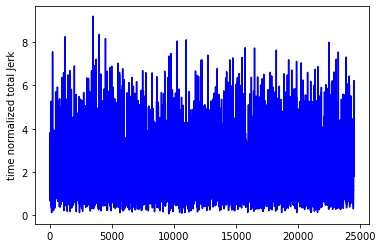

In [ ]:
#start time normalization 
time=np.arange(0,len(total_jerk),1)
I=[]

for i in range(len(peaks)-1):
    f=sci.interpolate.interp1d(time[peaks[i]:peaks[i+1]],total_jerk[peaks[i]:peaks[i+1]], fill_value="extrapolate")
    xnew=np.arange(peaks[i],peaks[i+1],(peaks[i+1]-peaks[i])/250)
    cycle=f(xnew)
    I=np.concatenate((I,cycle))
plt.plot(I,'b')
plt.ylabel('time normalized total Jerk')
plt.show()  

Minima of delayed mutual information from total Jerk  = [ 17  47  79 108 142 171 202 234 265 297 324 328 357 392 424 452 483 516
 548 578 608 626 643 671 673 675 702 733 766 796 800 825 857 875 877 893
 924 952 986]
Autocorrelation time from total jerk  = 7


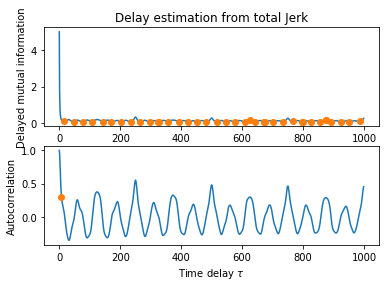

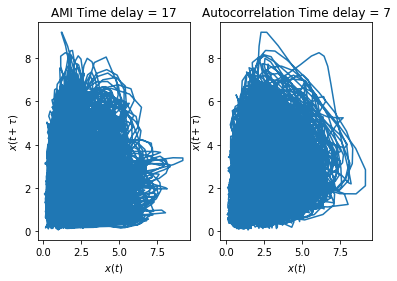

In [ ]:
lag = np.arange(1000)
rjt = delay.acorr(I, maxtau=1000)
ijt = delay.dmi(I, maxtau=1000)

i_delayjt = localmin(noise.sma(ijt, hwin=1)) + 1
r_delayjt= np.argmax(rjt < 1.0 / np.e)

print(r'Minima of delayed mutual information from total Jerk  = %s' % i_delayjt)
print(r'Autocorrelation time from total jerk  = %d' % r_delayjt)

plt.figure(1)

plt.subplot(211)
plt.title(r'Delay estimation from total Jerk')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, ijt, i_delayjt, ijt[i_delayjt], 'o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, rjt, r_delayjt, rjt[r_delayjt], 'o')

plt.figure(2)
plt.subplot(121)
plt.title(r'AMI Time delay = %d' % i_delayjt[0])
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(I[:-i_delayjt[0]], I[i_delayjt[0]:])

plt.subplot(122)
plt.title(r'Autocorrelation Time delay = %d' % r_delayjt)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(I[:-r_delayjt], I[r_delayjt:])

plt.show()

[False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[False False False False False False False False False False False False
 False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False]


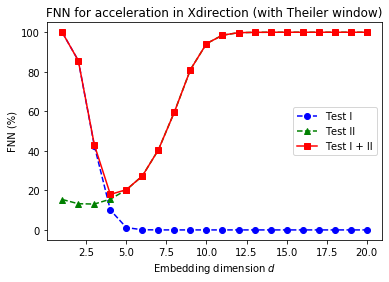

In [ ]:
#run false nearest neighbourhood algorithm to define the dimension 
tau=min(i_delayjt)
dim=np.arange(1,20+1)
f1, f2, f3=dimension.fnn(I, tau= tau, dim=dim, window=tau, metric='cityblock',maxnum=1000)

plt.figure(1)
plt.title(r'FNN for acceleration in Xdirection (with Theiler window)')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()
print(100*f1==0)
print(100*f2==0)
print(100*f3==0)

In [ ]:
edjt=100*f1==0
o=0
for i in edjt: 
    if i==False:
        o=o+1
    else:
        o+1
    
embedding_dimensionjt=o+1
print(embedding_dimensionjt)

8


In [ ]:
#calculate entropy
print('permutation entropy, total jerk:', perm_entropy(I, order=embedding_dimensionjt, delay=min(i_delayjt), normalize=True))                 # Permutation entropy
print('spectral entropy, total jerk:', spectral_entropy(I, 100, method='fft', normalize=True)) # Spectral entropy
print('singular value decomposition entrop, total jerk:',svd_entropy(I, order=embedding_dimensionjt, delay=min(i_delayjt), normalize=True))         # Singular value decomposition entropy
print('approximate entropy, total jerk:',app_entropy(I, order=embedding_dimensionjt, metric='chebyshev'))              # Approximate entropy
print('sample entropy, total jerk:',sample_entropy(I, order=embedding_dimensionjt, metric='chebyshev'))           # Sample entropy
      

permutation entropy, total jerk: 0.8702888480513403
spectral entropy, total jerk: 0.5774474391457702
singular value decomposition entrop, total jerk: 0.8805255430728641
approximate entropy, total jerk: 0.47793291778650193
sample entropy, total jerk: 0.43057281926732943


In [ ]:
#calculate Lyapunov from Rosenstein algorithm 
Lyjt=nolds.lyap_r(I, emb_dim=embedding_dimensionjt, lag=min(i_delayjt),tau=0.01,fit='poly')
print('Maximum Lyapunov Exponent from total jerk:', Lyjt)

#compute sample entropy 
SEjt=nolds.sampen(I, emb_dim=embedding_dimensionjt)
print('Sample Entropy of total jerk:', SEjt)

#compute Dettrended fluctuation Analysis 
DFAjt=nolds.dfa(I,fit_trend='poly',fit_exp='poly')
print('Detrended fluctuation  analysis of total jerk;', DFAjt)
#compute correlation dimension 

CDjt=nolds.corr_dim(I, embedding_dimensionjt,fit='poly')
print('Correlation Dimention of total jerk:', CDjt)

C:\ProgramData\Anaconda3\lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 6125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Maximum Lyapunov Exponent from total jerk: 0.16288370163621158
Sample Entropy of total jerk: 0.4305728192673296
Detrended fluctuation  analysis of total jerk; 0.7563919319830986
Correlation Dimention of total jerk: 3.4458349434493387


In [ ]:
#root man square 
RMSjt= np.power(((np.power(I,2))/I.shape), 0.5)
print('root mean square of total jerk:', RMSjt)

root mean square of total jerk: [0.01081936 0.01078782 0.01061304 ... 0.01685621 0.01814991 0.01920804]


In [ ]:
print('mean of RMS total jerk:',np.mean(RMSjt))
print('standard deviation of RMS total jerk:',np.std(RMSjt))
print('variance of RMS total jerk:',np.var(RMSjt))

mean of RMS total jerk: 0.013561512850546707
standard deviation of RMS total jerk: 0.008554830905392288
variance of RMS total jerk: 7.318513181985505e-05


(97,)

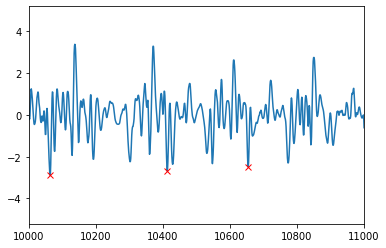

In [ ]:
peaks2,_=sci.signal.find_peaks(-jerkz,distance=200)
plt.plot(jerkz)
plt.plot(peaks2,jerkz[peaks2],'rx')
plt.xlim(10000,11000)
peaks2.shape

plt.plot(linaccelz1)
plt.plot(peaks2, linaccelz1[peaks2],'rx')
plt.xlim(10000,11000)

In [ ]:
Jerk_minimums=jerkz[peaks2]

In [ ]:
np.mean(Jerk_minimums)

-2.8542784702886537

In [ ]:
np.std(Jerk_minimums)

0.7908764848981612

In [ ]:
sci.stats.zscore(Jerk_minimums)

array([ 3.92340803, -0.63416477, -0.30527251, -0.67222459, -2.38420843,
       -2.19933729, -0.35963655, -0.58316513,  1.09911256, -1.1788851 ,
       -1.46815447,  1.32554046, -0.6354364 ,  1.41815895, -0.103226  ,
       -0.25011783, -0.31939038,  1.50157222, -0.76134877, -0.1896949 ,
       -0.21408563, -0.69353449,  0.17443673,  0.6693661 ,  0.64810579,
        0.11257686,  0.1866535 , -0.39344355, -0.80144263, -1.76276512,
       -0.34247709,  1.05975477,  0.20299409,  0.85816299,  0.82307415,
        0.51138805, -0.17522608, -0.05754334,  0.16783717, -0.04051787,
        0.22261963,  0.45527525,  1.02906729,  0.42012532,  0.3069708 ,
        1.0111193 ,  0.13389786,  0.35195467, -0.76915439, -1.20445316,
        0.39922158,  0.65272204,  1.71928442,  0.89532933, -0.279535  ,
        0.99913168, -0.45022776, -1.80711112,  0.66958906,  0.79576346,
        0.00990502,  1.79448367, -0.17951116,  0.13319747,  0.39421679,
        0.57754232, -1.33927417, -0.54320216, -0.44354055, -0.70

In [ ]:
np.var(Jerk_minimums)

0.6254856143648715

In [ ]:
np.median(Jerk_minimums)

-2.846444822408512

In [ ]:
sci.stats.mode(Jerk_minimums)

ModeResult(mode=array([-4.73989285]), count=array([1]))

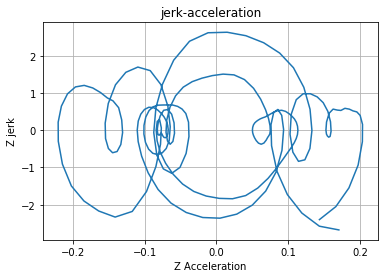

In [ ]:
plt.plot(linaccelz1[peaks2[40]:peaks2[41]],jerkz[peaks2[40]:peaks2[41]])
plt.xlabel('Z Acceleration')
plt.ylabel('Z jerk')
plt.title('jerk-acceleration')
plt.grid('on')

Minima of delayed mutual information from Z acceleration  = [ 5 15 20 24 27 32 42 51 55 58 64 66 69 72 79 81 83 86 92 97]
Autocorrelation time from Z acceleration  = 5


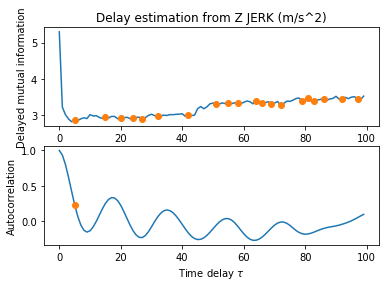

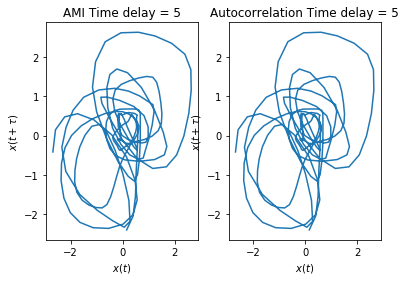

In [ ]:
jerkz=jerkz[peaks2[40]:peaks2[41]]
lag = np.arange(100)
rJx = delay.acorr(jerkz, maxtau=100)
iJx = delay.dmi(jerkz, maxtau=100)

i_delayJx = localmin(noise.sma(iJx, hwin=1)) + 1
r_delayJx= np.argmax(rJx < 1.0 / np.e)

print(r'Minima of delayed mutual information from Z acceleration  = %s' % i_delayJx)
print(r'Autocorrelation time from Z acceleration  = %d' % r_delayJx)

plt.figure(1)

plt.subplot(211)
plt.title(r'Delay estimation from Z JERK (m/s^2)')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, iJx, i_delayJx, iJx[i_delayJx], 'o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, rJx, r_delayJx, rJx[r_delayJx], 'o')

plt.figure(2)
plt.subplot(121)
plt.title(r'AMI Time delay = %d' % i_delayJx[0])
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(jerkz[:-i_delayJx[0]], jerkz[i_delayJx[0]:])

plt.subplot(122)
plt.title(r'Autocorrelation Time delay = %d' % r_delayJx)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(jerkz[:-r_delayJx], jerkz[r_delayJx:])

plt.show()

array([False, False, False, False, False, False,  True,  True,  True,
        True])

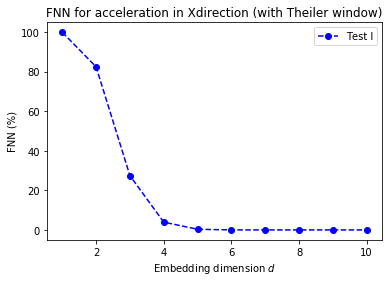

In [ ]:
#run false nearest neighbourhood algorithm to define the dimension 
tau=min(i_delayz)
dim=np.arange(1,10+1)
f1, f2, f3=dimension.fnn(D, tau= tau, dim=dim, window=tau, metric='cityblock')

plt.figure(1)
plt.title(r'FNN for acceleration in Xdirection (with Theiler window)')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
#plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
#plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()
100*f1==0

In [ ]:
print(petrosian_fd(B))            # Petrosian fractal dimension
print(katz_fd(B))                 # Katz fractal dimension
print(higuchi_fd(B, kmax=10))     # Higuchi fractal dimension
print(detrended_fluctuation(B))   # Detrended fluctuation analysis

1.002855088171387
2.873994312797225
1.0814033927750717
0.7242488605008978


In [ ]:
#define a dataframe in pandas to put the results in it 
row_label=['X Acceleration', 'Y Acceleration', 'Z Acceleration','total acceleration' ,'X jerk', 'Y Jerk','Z Jerk', 'total jerk']
first_round_results=pd.DataFrame(data={}, index=row_label)

first_round_results['time delay']=[min(i_delayx),min(i_delayy),min(i_delayz),min(i_delaytotalaccel),min(i_delayjx),min(i_delayjy),min(i_delayjz),min(i_delayjt)]

first_round_results['embedding dimension']=[embedding_dimensionx,embedding_dimensiony,embedding_dimensionz,embedding_dimensionta,embedding_dimensionjx,embedding_dimensionjy,embedding_dimensionjz,embedding_dimensionjt]

first_round_results['Lyapunove Exp.(Rosenstein)']=[Lyx,Lyy,Lyz,Lytotalaccel,Lyjx,Lyjy,Lyjz,Lyjt]

first_round_results['Detrended Fluctuation Analysis']=[DFAx,DFAy,DFAz,DFAtotalaccel,DFAjx,DFAjy,DFAjz,DFAjt]

first_round_results['Correlation Dimension']=[CDx,CDy,CDz,CDtotalaccel,CDjx,CDjy,CDjz,CDjt]

first_round_results['Sample Entropy']=[SEx,SEy,SEz,SEtotalaccel,SEjx,SEjy,SEjz,SEjt]

first_round_results['permutation Entropy']=[perm_entropy(B, order=embedding_dimensionx, delay=min(i_delayx), normalize=True),
                                            perm_entropy(C, order=embedding_dimensiony, delay=min(i_delayy), normalize=True),
                                            perm_entropy(D, order=embedding_dimensionz, delay=min(i_delayz), normalize=True),
                                            perm_entropy(E, order=embedding_dimensionta, delay=min(i_delaytotalaccel), normalize=True),
                                            perm_entropy(F, order=embedding_dimensionjx, delay=min(i_delayjx), normalize=True),
                                            perm_entropy(G, order=embedding_dimensionjy, delay=min(i_delayjy), normalize=True),
                                            perm_entropy(H, order=embedding_dimensionjz, delay=min(i_delayjz), normalize=True),
                                            perm_entropy(I, order=embedding_dimensionjt, delay=min(i_delayjt), normalize=True)]

first_round_results['spectral Entropy']=[spectral_entropy(B, 100, method='fft', normalize=True),
                                        spectral_entropy(C, 100, method='fft', normalize=True),
                                        spectral_entropy(D, 100, method='fft', normalize=True),
                                        spectral_entropy(E, 100, method='fft', normalize=True),
                                        spectral_entropy(F, 100, method='fft', normalize=True),
                                        spectral_entropy(G, 100, method='fft', normalize=True),
                                        spectral_entropy(H, 100, method='fft', normalize=True),
                                        spectral_entropy(I, 100, method='fft', normalize=True)]

first_round_results['Singular Value Decomposition']=[svd_entropy(B, order=embedding_dimensionx, delay=min(i_delayx), normalize=True),
                                                    svd_entropy(C, order=embedding_dimensiony, delay=min(i_delayy), normalize=True),
                                                    svd_entropy(D, order=embedding_dimensionz, delay=min(i_delayz), normalize=True),
                                                    svd_entropy(E, order=embedding_dimensionta, delay=min(i_delaytotalaccel), normalize=True),
                                                    svd_entropy(F, order=embedding_dimensionjx, delay=min(i_delayjx), normalize=True),
                                                    svd_entropy(G, order=embedding_dimensionjy, delay=min(i_delayjy), normalize=True),
                                                    svd_entropy(H, order=embedding_dimensionjz, delay=min(i_delayjz), normalize=True),
                                                    svd_entropy(I, order=embedding_dimensionjt, delay=min(i_delayjt), normalize=True)]

first_round_results['Approximate Entropy']=[app_entropy(B, order=embedding_dimensionx, metric='chebyshev'),
                        app_entropy(C, order=embedding_dimensiony, metric='chebyshev'),
                        app_entropy(D, order=embedding_dimensionz, metric='chebyshev'),
                        app_entropy(E, order=embedding_dimensionta, metric='chebyshev'),
                        app_entropy(F, order=embedding_dimensionjx, metric='chebyshev'),
                        app_entropy(G, order=embedding_dimensionjy, metric='chebyshev'),
                        app_entropy(H, order=embedding_dimensionjz, metric='chebyshev'),
                        app_entropy(I, order=embedding_dimensionjt, metric='chebyshev')]

first_round_results

from pandas import ExcelWriter

writer = ExcelWriter('1st round Results.xlsx', engine='xlsxwriter')
first_round_results.to_excel(writer,sheet_name='first round')

writer.save()